<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D5_Mysteries/student/W2D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D5_Mysteries/student/W2D5_Tutorial1.ipynb"  target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 1: Consciousness

**Week 2, Day 5: Mysteries**

**By Neuromatch Academy**

__Content creators:__ Samuele Bolotta, Juan David Vargas, Megan Peters, Steve Fleming, Guillaume Dumas, Joseph LeDoux, Matthias Michel, Daniel Dennett, Hakwan Lau, Anil Seth

__Content reviewers:__ Samuele Bolotta, Lily Chamakura, RyeongKyung Yoon, Yizhou Chen, Ruiyi Zhang

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk


___


# Tutorial Objectives

*Estimated timing of tutorial: 120 minutes*

By the end of this tutorial, participants will be able to:

1. Understand and distinguish various aspects of consciousness including the hard problem of consciousness, the difference between phenomenal consciousness and access consciousness, as well as the distinctions between consciousness and sentience or intelligence

2. Explore core frameworks for analyzing consciousness, including diagnostic criteria, and will compare objective probabilities with subjective credences

3. Delve into reductionist theories of consciousness, such as Global Workspace Theory (GWT), theories of metacognition, and Higher-Order Thought (HOT) theories.


In [1]:
# @markdown
from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()
with out:
    print(f"If you want to download the slides: https://osf.io/download/wm9dp/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/wm9dp/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---
# Setup



##  Install and import feedback gadget


In [2]:
# @title Install and import feedback gadget

!pip install vibecheck numpy matplotlib Pillow torch torchvision transformers ipywidgets gradio trdg scikit-learn networkx pickleshare seaborn tabulate --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt - leave this as is
        notebook_section,
        {
        "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",  
        "name": "sciencematch_sm", # change the name of the course : neuromatch_dl, climatematch_ct, etc
        "user_key": "y1x3mpx5",
        },
    ).render()

feedback_prefix = "W2D5_T1"


In [3]:
# @title Import dependencies
# @markdown Enhanced organization and clarity in import statements for better readability

# Standard Libraries
import copy
import logging
import os
import random
import requests

# Data Handling and Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, fbeta_score
from sklearn.linear_model import LinearRegression
from tabulate import tabulate

# Scientific Computing and Statistical Libraries
from numpy.linalg import inv
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

# Deep Learning Libraries
import torch
from torch import nn, optim, save, load
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.nn.init as init
from torch.optim.lr_scheduler import StepLR

# Image Processing Libraries
from PIL import Image
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

# Interactive Elements and Web Applications
from IPython.display import IFrame
from IPython.display import Image as IMG
import gradio as gr
import ipywidgets as widgets
from ipywidgets import interact, IntSlider

# Graph Analysis Libraries
import networkx as nx

# Progress Monitoring Libraries
from tqdm import tqdm

# Utilities and Miscellaneous Libraries
from itertools import product

##  Figure Settings


In [4]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

## Helper Functions

In [5]:
#@title Helper functions
# @markdown

class FirstOrderNetwork(nn.Module):
    def __init__(self, hidden_units, data_factor, use_gelu):
        """
        Initializes the FirstOrderNetwork with specific configurations.

        Parameters:
        - hidden_units (int): The number of units in the hidden layer.
        - data_factor (int): Factor to scale the amount of data processed.
                             A factor of 1 indicates the default data amount,
                             while 10 indicates 10 times the default amount.
        - use_gelu (bool): Flag to use GELU (True) or ReLU (False) as the activation function.
        """
        super(FirstOrderNetwork, self).__init__()

        # Define the encoder, hidden, and decoder layers with specified units
        self.encoder = nn.Linear(100, hidden_units)
        self.hidden = nn.Linear(hidden_units, hidden_units)
        self.decoder = nn.Linear(hidden_units, 100)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.3)

        # Temperature parameter for activation sharpness control
        self.temperature = 1.0

        # Set the data factor
        self.data_factor = data_factor

        # Choose the activation function based on the use_gelu flag
        self.activation = nn.GELU() if use_gelu else nn.ReLU()

        # Other activation functions for various purposes
        self.sigmoid = torch.sigmoid
        self.softmax = nn.Softmax(dim=1)
        self.tanh = torch.tanh

        # Initialize network weights
        self.initialize_weights()

    def initialize_weights(self):
        """Initializes weights of the encoder, hidden, and decoder layers uniformly."""
        init.uniform_(self.encoder.weight, -1.0, 1.0)
        init.uniform_(self.hidden.weight, -1.0, 1.0)
        init.uniform_(self.decoder.weight, -1.0, 1.0)

    def forward(self, x):
        """
        Defines the forward pass through the network.

        Parameters:
        - x (Tensor): The input tensor to the network.

        Returns:
        - Tensor: The output of the network after passing through the layers and activations.
        """
        # Encoder step with dropout and sigmoid activation
        x = self.dropout(self.sigmoid(self.encoder(x) / self.temperature))

        # Hidden layer step with dropout and sigmoid activation
        x = self.dropout(self.sigmoid(self.hidden(x) / self.temperature))

        # Decoder step with dropout and sigmoid activation
        output = self.dropout(self.sigmoid(self.decoder(x) / self.temperature))

        # Adjust output based on a threshold
        output = torch.where(output > 0.5, output + 0.12, output)

        return output

def initialize_global():
    global Input_Size_1, Hidden_Size_1, Output_Size_1, Input_Size_2
    global num_units, patterns_number
    global learning_rate_1, learning_rate_2, n_epochs, momentum, temperature , Threshold
    global First_set, Second_set, Third_set
    global First_set_targets, Second_set_targets, Third_set_targets
    global epoch_list, epoch_1_order, epoch_2_order, patterns_matrix1
    global Testing_graph_names

    # Network sizes
    Input_Size_1 = 100
    Hidden_Size_1 = 60
    Output_Size_1 = 100
    Input_Size_2 = 100

    # Patterns
    num_units = 100
    patterns_number = 200

    # Pre-training and hyperparameters
    learning_rate_1 = 0.9
    learning_rate_2 = 0.1
    n_epochs = 200
    momentum = 0.0
    temperature = 1.0
    Threshold=0.5

    # Testing
    First_set = []
    Second_set = []
    Third_set = []
    First_set_targets = []
    Second_set_targets = []
    Third_set_targets = []

    Testing_graph_names = ["Suprathreshold stimulus", "Subthreshold stimulus", "Low Vision"]


    # Graphic of pretraining
    epoch_list = list(range(1, n_epochs + 1))
    epoch_1_order = np.zeros(n_epochs)
    epoch_2_order = np.zeros(n_epochs)
    patterns_matrix1 =  torch.zeros((n_epochs, patterns_number), device=device)  # Initialize patterns_matrix as a PyTorch tensor on the GPU

class SecondOrderNetwork(nn.Module):
    def __init__(self, use_gelu):
        super(SecondOrderNetwork, self).__init__()
        # Define a linear layer for comparing the difference between input and output of the first-order network
        self.comparison_layer = nn.Linear(100, 100)

        # Linear layer for determining wagers, mapping from 100 features to a single output
        self.wager = nn.Linear(100, 1)

        # Dropout layer to prevent overfitting by randomly setting input units to 0 with a probability of 0.3 during training
        self.dropout = nn.Dropout(0.3)

        # Select activation function based on the `use_gelu` flag
        self.activation = torch.nn.GELU() if use_gelu else torch.relu

        # Additional activation functions for potential use in network operations
        self.sigmoid = torch.sigmoid
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax for multi-class classification problems
        self.tanh = torch.tanh

        # Initialize the weights of the network
        self._init_weights()

    def _init_weights(self):
        # Uniformly initialize weights for the comparison and wager layers
        init.uniform_(self.comparison_layer.weight, -1.0, 1.0)
        init.uniform_(self.wager.weight, 0.0, 0.1)

    def forward(self, first_order_input, first_order_output):
        # Calculate the difference between the first-order input and output
        comparison_matrix = first_order_input - first_order_output

        # Pass the difference through the comparison layer and apply the chosen activation function
        comparison_out = self.comparison_layer(comparison_matrix)

        # Calculate the wager value, applying dropout and sigmoid activation to the output of the wager layer
        wager = self.dropout(self.sigmoid(self.wager(comparison_out)))

        return wager

def compute_metrics(TP, FP, FN):
    """Compute precision, recall, and F1 score."""
    precision = round(TP / (TP + FP), 2) if (TP + FP) > 0 else 0
    recall = round(TP / (TP + FN), 2) if (TP + FN) > 0 else 0
    f1_score = round(2 * (precision * recall) / (precision + recall), 2) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

def create_patterns(stimulus):
    """
    Generates neural network input patterns based on specified stimulus conditions.

    Parameters:
    - stimulus (int): Determines the type of patterns to generate.
                      Acceptable values:
                      - 0: Suprathreshold stimulus
                      - 1: Subthreshold stimulus
                      - 2: Low vision condition

    Returns:
    - torch.Tensor: Tensor of generated patterns.
    - torch.Tensor: Tensor of target values corresponding to the generated patterns.
    """

    # Generate initial patterns and target tensors for base condition.
    patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

    if stimulus == 0:  # Suprathreshold stimulus condition
        # Convert pattern tensors for processing on specified device (CPU/GPU).
        patterns = torch.Tensor(patterns_tensor).to(device)
        targets = torch.Tensor(stim_present_tensor).to(device)

    elif stimulus == 1:  # Subthreshold stimulus condition, simulating blindsight with added noise
        patterns, targets = generate_subthreshold_patterns(patterns_number, num_units, device)

    elif stimulus == 2:  # Low vision condition, reducing stimulus activation
        patterns, targets = generate_low_vision_patterns(patterns_number, num_units, device)

    else:
        raise ValueError("Invalid stimulus ID for testing patterns creation.")

    return patterns, targets

def generate_subthreshold_patterns(patterns_number, num_units, device):
    """
    Generates patterns and targets for the subthreshold stimulus condition by adding noise.

    Parameters:
    - patterns_number (int): Number of patterns to generate.
    - num_units (int): Number of units in each pattern.
    - device: The device (CPU/GPU) for tensor operations.

    Returns:
    - Tuple containing two lists of torch.Tensor: (patterns, targets)
    """
    patterns, targets = [], []
    for i in range(patterns_number):
        pattern = np.random.uniform(0.0, 0.02, num_units) + 0.0012  # Base pattern with noise
        if i >= 100:
            stimulus_number = random.randint(0, 99)  # Selecting unit for stimulus
            pattern[stimulus_number] = np.random.uniform(0.0, 1.0) + 0.0012
            present = np.zeros(num_units)
            present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.5 else 0.0
            targets.append(present)
        patterns.append(pattern)
    # Convert lists to tensors for device processing.
    return torch.Tensor(patterns).to(device), torch.Tensor(targets).to(device)

def generate_low_vision_patterns(patterns_number, num_units, device):
    """
    Generates patterns and targets for the low vision condition by reducing stimulus activation.

    Parameters:
    - patterns_number (int): Number of patterns to generate.
    - num_units (int): Number of units in each pattern.
    - device: The device (CPU/GPU) for tensor operations.

    Returns:
    - Tuple containing two lists of torch.Tensor: (patterns, targets)
    """
    patterns, targets = [], []
    for i in range(patterns_number):
        pattern = np.random.uniform(0.0, 0.02, num_units)
        if i >= 100:
            stimulus_number = random.randint(0, 99)
            pattern[stimulus_number] = np.random.uniform(0.0, 0.3)
            present = np.zeros(num_units)
            present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.15 else 0.0
            targets.append(present)
        patterns.append(pattern)
    # Convert lists to tensors for device processing.
    return torch.Tensor(patterns).to(device), torch.Tensor(targets).to(device)

  #define the architecture, optimizers, loss functions, and schedulers for pre training
def prepare_pre_training(hidden,factor,gelu,stepsize, gam):

  first_order_network = FirstOrderNetwork(hidden,factor,gelu).to(device)
  second_order_network = SecondOrderNetwork(gelu).to(device)

  criterion_1 = nn.MSELoss()
  criterion_2 = nn.MSELoss()

  optimizer_1 = optim.SGD(first_order_network.parameters(), lr=learning_rate_1, momentum=momentum)
  optimizer_2 = optim.SGD(second_order_network.parameters(), lr=learning_rate_2, momentum=momentum)


  # Learning rate schedulers
  scheduler_1 = StepLR(optimizer_1, step_size=stepsize, gamma=gam)
  scheduler_2 = StepLR(optimizer_2, step_size=stepsize, gamma=gam)

  return first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2

def title(string):
  #plot the title of the currently trained model, inside a rectangle
  fig, ax = plt.subplots()
  rectangle = patches.Rectangle((0.05, 0.1), 0.9 , 0.4, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.5)
  ax.add_patch(rectangle)
  plt.text(0.5, 0.3, string , horizontalalignment='center', verticalalignment='center', fontsize=26, color='white')
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  ax.axis('off')
  plt.show()
  plt.close(fig)

# Function to configure the training environment and load the models
def config_training(first_order_network, second_order_network, hidden, factor, gelu):
    """
    Configures the training environment by saving the state of the given models and loading them back.
    Initializes testing patterns for evaluation.

    Parameters:
    - first_order_network: The first order network instance.
    - second_order_network: The second order network instance.
    - hidden: Number of hidden units in the first order network.
    - factor: Factor influencing the network's architecture.
    - gelu: Activation function to be used in the network.

    Returns:
    - Tuple of testing patterns, number of samples in the testing patterns, and the loaded model instances.
    """
    # Paths where the models' states will be saved
    PATH = './cnn1.pth'
    PATH_2 = './cnn2.pth'

    # Save the weights of the pretrained networks to the specified paths
    torch.save(first_order_network.state_dict(), PATH)
    torch.save(second_order_network.state_dict(), PATH_2)

    # Generating testing patterns for three different sets
    First_set, First_set_targets = create_patterns(0)
    Second_set, Second_set_targets = create_patterns(1)
    Third_set, Third_set_targets = create_patterns(2)

    # Aggregate testing patterns and their targets for ease of access
    Testing_patterns = [[First_set, First_set_targets], [Second_set, Second_set_targets], [Third_set, Third_set_targets]]

    # Determine the number of samples from the first set (assumed consistent across all sets)
    n_samples = len(Testing_patterns[0][0])

    # Initialize and load the saved states into model instances
    loaded_model = FirstOrderNetwork(hidden, factor, gelu)
    loaded_model_2 = SecondOrderNetwork(gelu)

    loaded_model.load_state_dict(torch.load(PATH))
    loaded_model_2.load_state_dict(torch.load(PATH_2))

    # Ensure the models are moved to the appropriate device (CPU/GPU) and set to evaluation mode
    loaded_model.to(device)
    loaded_model_2.to(device)

    loaded_model.eval()
    loaded_model_2.eval()

    return Testing_patterns, n_samples, loaded_model, loaded_model_2

# Function to test the model using the configured testing patterns
def testing(Testing_patterns, n_samples, loaded_model, loaded_model_2):
    """
    Tests the model on provided testing patterns and calculates F1 scores and other metrics for analysis.

    Parameters:
    - Testing_patterns: A list of testing datasets and their targets.
    - n_samples: Number of samples in each testing dataset.
    - loaded_model: The loaded first order network model for testing.
    - loaded_model_2: The loaded second order network model for testing.

    Returns:
    - F1 scores for high and low wager scenarios, and results for plotting.
    """
    results_for_plotting = []

    f1_scores_high_wager = []
    f1_scores_low_wager = []

    # Iterate through each set of testing patterns and targets
    for i in range(len(Testing_patterns)):
        with torch.no_grad():  # Ensure no gradients are computed during testing
            # Obtain output from the first order model
            output_first_order = loaded_model(Testing_patterns[i][0])
            # Focus on the last 100 elements for wagering analysis
            last_100_elements_wager = output_first_order[-100:].cpu()
            max_values = last_100_elements_wager.max(dim=1).values

            _, targets_2 = torch.max(Testing_patterns[i][1], 1)
            targets_2 = targets_2[-100:].cpu()
            # Convert targets to binary classification for wagering scenario
            targets_2 = (targets_2 > 0).int()

            # Convert tensors to NumPy arrays for metric calculations
            predicted_np = max_values.numpy()
            targets_2_np = targets_2.numpy()

            # Calculate True Positives, True Negatives, False Positives, and False Negatives
            TP = np.sum((predicted_np > 0.5) & (targets_2_np > 0.5))
            TN = np.sum((predicted_np < 0.5) & (targets_2_np < 0.5))
            FP = np.sum((predicted_np > 0.5) & (targets_2_np < 0.5))
            FN = np.sum((predicted_np < 0.5) & (targets_2_np > 0.5))

            # Compute precision, recall, and F1 score for both high and low wager scenarios
            precision_h, recall_h, f1_score_h = compute_metrics(TP, FP, FN)
            precision_l, recall_l, f1_score_l = compute_metrics(TP, FP, FN)

            f1_scores_high_wager.append(f1_score_h)
            f1_scores_low_wager.append(f1_score_l)

            # Collect results for plotting
            results_for_plotting.append({
                "counts": [[TP, FP, TP + FP], [FN, TN, FN + TN], [TP + FN, FP + TN, TP + FP + FN + TN]],
                "metrics": [[precision_h, recall_h, f1_score_h], [precision_l, recall_l, f1_score_l]],
                "title_results": f"Results Table - Set {i+1}",
                "title_metrics": f"Metrics Table - Set {i+1}"
            })

    return f1_scores_high_wager, f1_scores_low_wager, results_for_plotting

def Generate_Patterns(patterns_number, num_units):
    # Generates patterns and targets for training the networks
    # patterns_number: Number of patterns to generate
    # num_units: Number of units in each pattern
    # Returns lists of patterns, stimulus present/absent indicators, and second order targets

    patterns = []  # Store generated patterns
    stim_present = []  # Indicators for when a stimulus is present in the pattern
    stim_absent = []  # Indicators for when no stimulus is present
    order_2_pr = []  # Second order network targets based on the presence or absence of stimulus

    # Generate patterns, half noise and half potential stimuli
    for i in range(patterns_number):
        # First half: Noise patterns
        if i < patterns_number // 2:
            pattern = np.random.uniform(0.0, 0.02, num_units)  # Generate a noise pattern
            patterns.append(pattern)
            stim_present.append(np.zeros(num_units))  # Stimulus absent
            stim_absent.append(np.zeros(num_units))  # Redundant, consider removing
            order_2_pr.append([0.0 , 1.0])  # No stimulus, low wager
        # Second half: Stimulus patterns
        else:
            stimulus_number = random.randint(0, num_units - 1)  # Choose a unit for potential stimulus
            pattern = np.random.uniform(0.0, 0.02, num_units)
            pattern[stimulus_number] = np.random.uniform(0.0, 1.0)  # Set stimulus intensity
            patterns.append(pattern)
            present = np.zeros(num_units)
            # Determine if stimulus is above discrimination threshold
            if pattern[stimulus_number] >= 0.5:
                order_2_pr.append([1.0 , 0.0])  # Stimulus detected, high wager
                present[stimulus_number] = 1.0
            else:
                order_2_pr.append([0.0 , 1.0])  # Stimulus not detected, low wager
                present[stimulus_number] = 0.0
            stim_present.append(present)
            stim_absent.append(np.zeros(num_units))  # Redundant, consider removing

    patterns_tensor = torch.Tensor(patterns).to(device)
    stim_present_tensor = torch.Tensor(stim_present).to(device)
    stim_absent_tensor= torch.Tensor(stim_absent).to(device)
    order_2_tensor = torch.Tensor(order_2_pr).to(device)

    return patterns_tensor, stim_present_tensor , stim_absent_tensor, order_2_tensor

def create_patterns(stimulus):
    """
    Generates neural network input patterns based on specified stimulus conditions.

    Parameters:
    - stimulus (int): Determines the type of patterns to generate.
                      Acceptable values:
                      - 0: Suprathreshold stimulus
                      - 1: Subthreshold stimulus
                      - 2: Low vision condition

    Returns:
    - torch.Tensor: Tensor of generated patterns.
    - torch.Tensor: Tensor of target values corresponding to the generated patterns.
    """

    # Generate initial patterns and target tensors for base condition.
    patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

    if stimulus == 0:  # Suprathreshold stimulus condition
        # Convert pattern tensors for processing on specified device (CPU/GPU).
        patterns = torch.Tensor(patterns_tensor).to(device)
        targets = torch.Tensor(stim_present_tensor).to(device)

    elif stimulus == 1:  # Subthreshold stimulus condition, simulating blindsight with added noise
        patterns, targets = generate_subthreshold_patterns(patterns_number, num_units, device)

    elif stimulus == 2:  # Low vision condition, reducing stimulus activation
        patterns, targets = generate_low_vision_patterns(patterns_number, num_units, device)

    else:
        raise ValueError("Invalid stimulus ID for testing patterns creation.")

    return patterns, targets

def generate_subthreshold_patterns(patterns_number, num_units, device):
    """
    Generates patterns and targets for the subthreshold stimulus condition by adding noise.

    Parameters:
    - patterns_number (int): Number of patterns to generate.
    - num_units (int): Number of units in each pattern.
    - device: The device (CPU/GPU) for tensor operations.

    Returns:
    - Tuple containing two lists of torch.Tensor: (patterns, targets)
    """
    patterns, targets = [], []
    for i in range(patterns_number):
        pattern = np.random.uniform(0.0, 0.02, num_units) + 0.0012  # Base pattern with noise
        if i >= 100:
            stimulus_number = random.randint(0, 99)  # Selecting unit for stimulus
            pattern[stimulus_number] = np.random.uniform(0.0, 1.0) + 0.0012
            present = np.zeros(num_units)
            present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.5 else 0.0
            targets.append(present)
        patterns.append(pattern)
    # Convert lists to tensors for device processing.
    return torch.Tensor(patterns).to(device), torch.Tensor(targets).to(device)

def generate_low_vision_patterns(patterns_number, num_units, device):
    """
    Generates patterns and targets for the low vision condition by reducing stimulus activation.

    Parameters:
    - patterns_number (int): Number of patterns to generate.
    - num_units (int): Number of units in each pattern.
    - device: The device (CPU/GPU) for tensor operations.

    Returns:
    - Tuple containing two lists of torch.Tensor: (patterns, targets)
    """
    patterns, targets = [], []
    for i in range(patterns_number):
        pattern = np.random.uniform(0.0, 0.02, num_units)
        if i >= 100:
            stimulus_number = random.randint(0, 99)
            pattern[stimulus_number] = np.random.uniform(0.0, 0.3)
            present = np.zeros(num_units)
            present[stimulus_number] = 1.0 if pattern[stimulus_number] >= 0.15 else 0.0
            targets.append(present)
        patterns.append(pattern)
    # Convert lists to tensors for device processing.
    return torch.Tensor(patterns).to(device), torch.Tensor(targets).to(device)

## Plotting Functions

In [6]:
# @title Plotting functions
# @markdown

def plot_signal_max_and_indicator(patterns_tensor, plot_title="Training Signals"):
    """
    Plots the maximum values of signal units and a binary indicator for max values greater than 0.5.

    Parameters:
    - patterns_tensor: A tensor containing signals, where each signal is expected to have multiple units.
    """

    # Calculate the maximum value of units for each signal within the patterns tensor
    max_values_of_units = patterns_tensor.max(dim=1).values.cpu().numpy()  # Ensure it's on CPU and in NumPy format for plotting

    # Determine the binary indicators based on the max value being greater than 0.5
    binary_indicators = (max_values_of_units > 0.5).astype(int)

    # Create a figure with 2 subplots (2 rows, 1 column)
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    fig.suptitle(plot_title, fontsize=16)  # Set the overall title for the plot

    # First subplot for the maximum values of each signal
    axs[0].plot(range(patterns_tensor.size(0)), max_values_of_units, drawstyle='steps-mid')
    axs[0].set_xlabel('Signal Number')
    axs[0].set_ylabel('Max Value of Signal Units')
    axs[0].grid(True)

    # Second subplot for the binary indicators
    axs[1].plot(range(patterns_tensor.size(0)), binary_indicators, drawstyle='steps-mid', color='red')
    axs[1].set_xlabel('Signal Number')
    axs[1].set_ylabel('Indicator (Max > 0.5) in each signal')
    axs[1].set_ylim(-0.1, 1.1)  # Adjust y-axis limits for clarity
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def pre_train_plots(epoch_1_order, epoch_2_order, title):
    # LOSS PLOTS
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

    # First graph for 1st Order Network
    ax1.plot(epoch_list, epoch_1_order, linestyle='--', marker='o', color='g')
    ax1.set_title('1st Order Network Loss')
    ax1.set_xlabel('Epochs - Pretraining Phase')
    ax1.set_ylabel('Loss')

    # Second graph for 2nd Order Network
    ax2.plot(epoch_list, epoch_2_order, linestyle='--', marker='o', color='b')
    ax2.set_title('2nd Order Network Loss')
    ax2.set_xlabel('Epochs - Pretraining Phase')
    ax2.set_ylabel('Loss')

    plt.suptitle(title, fontsize=16, y=0.95)

    plt.tight_layout()
    plt.savefig('Blindsight_Pre_training_Loss_{}.png'.format(title.replace(" ", "_").replace("/", "_")), bbox_inches='tight')
    plt.show()
    plt.close(fig)

def plot_testing(results_for_plotting , title):
    """Plot a table focused on 'PRECISION', 'RECALL', 'F1 SCORE', indicating consciousness level and testing scenario."""
    fig, ax = plt.subplots(figsize=(10, len(results_for_plotting) * 2 + 2))  # Adjusted for added header space
    ax.axis('off')
    ax.axis('tight')

    # Define column labels
    col_labels = ["Scenario", "Consciousness Level", "PRECISION", "RECALL", "F1 SCORE"]

    # Initialize list to hold all rows of data including headers
    full_data = []

    # Process each result to extract and prepare the data rows
    for i, result in enumerate(results_for_plotting):
        for level, metrics in zip(["High Consciousness", "Low Consciousness"], result["metrics"]):
            row = [Testing_graph_names[i], level] + metrics
            full_data.append(row)

    # Extract metric values for color scaling (excluding the first two columns which are text)
    metric_values = np.array(full_data)[:, 2:].astype(float)  # Convert to float for color scaling
    max_value = np.max(metric_values)
    colors = metric_values / max_value  # Normalize for color mapping

    # Prepare colors for all cells, defaulting to white for non-metric cells
    cell_colors = [["white", "white"] + list(row) for row in plt.cm.RdYlGn(colors)]

    # Create the table with cell colors
    table = ax.table(cellText=full_data, colLabels=col_labels, loc='center', cellLoc='center', cellColours=cell_colors)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.title(title, pad=20, fontsize=16)
    plt.show()

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.
# @markdown

# inform the user if the notebook uses GPU or CPU.

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

# Section 1: Global Neural Workspace

## Video 1

In [8]:
# @title Video 1

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'v1jaOTisBGM')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

## Section 1a: Modularity Of The Mind

In this section, we are exploring an important concept in machine learning: the idea that the complexity we observe in the physical world often arises from simpler, independently functioning parts. Think of the world as being made up of different modules or units that usually operate on their own but sometimes interact with each other. This is similar to how different apps on your phone work independently but can share information when needed.

This idea is closely linked to a field called causal inference, which involves studying how these separate units or mechanisms cause and influence each other. The goal is to understand and model how these mechanisms work both individually and together. Importantly, these mechanisms often interact only minimally, which means they can keep working properly even if changes occur in other parts. This characteristic makes them very robust, or capable of handling disturbances well. 

A specific example from machine learning that uses this idea is called Recurrent Independent Mechanisms (RIMs). In RIMs, different parts of the model mostly work independently, but they can also communicate or "pay attention" to each other when it’s necessary. This setup allows for efficient and dynamic processing of information. The research paper available here (https://arxiv.org/pdf/1909.10893) discusses this approach in detail. It highlights the benefits of designing models that recognize and utilize the independence and occasional interactions of these mechanisms. Such models are often more adaptable and can generalize better, meaning they perform well across a variety of different tasks or situations.

![Picture which shows how RIMs work over two steps.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D5_Mysteries/static/RIMs.png?raw=true)

This figure shows how RIMs work over two steps. 

- Query generation: each RIM starts by creating a query. This query helps each RIM pull out the necessary information from the data it receives at that moment.
- Attention-based selection: on the right side of the figure, you can see that some RIMs are chosen to be active (colored in blue) and others stay inactive (colored in white). This selection is made using a special scoring system called attention, which picks RIMs based on how relevant they are to the current visual inputs.
- State transition for active RIMs: the RIMs that get activated update their internal states according to their specific rules, using the information they've gathered. The RIMs that aren’t activated don’t change and keep their previous states.
- Communication between RIMs: finally, the active RIMs share information with each other, but this communication is limited. They use a system similar to key-value pairing, which helps them share only the most important information needed for the next step.

To make this more concrete, consider the example of modeling the motion of two balls. We can think of each ball as an independent mechanism. Although both balls are affected by Earth’s gravity, and very slightly by each other, they generally move independently. They only interact significantly when they collide. This model captures the essence of independent mechanisms interacting sparsely, a key idea in developing more effective and generalizable AI systems.

Now, let's download the RIM model!

In [9]:
# @title Data retrieval
# @markdown

# URL of the repository to clone
!git clone https://github.com/SamueleBolotta/RIMs-Sequential-MNIST
%cd RIMs-Sequential-MNIST

# Imports
from data import MnistData
from networks import MnistModel, LSTM

# Function to download files
def download_file(url, destination):
    print(f"Starting to download {url} to {destination}")
    response = requests.get(url, allow_redirects=True)
    open(destination, 'wb').write(response.content)
    print(f"Successfully downloaded {url} to {destination}")

# Path of the models
model_path = {
    'LSTM': 'lstm_model_dir/lstm_best_model.pt',
    'RIM': 'rim_model_dir/best_model.pt'
}

# URLs of the models
model_urls = {
    'LSTM': 'https://osf.io/4gajq/download',
    'RIM': 'https://osf.io/3squn/download'
}

# Check if model files exist, if not, download them
for model_key, model_url in model_urls.items():
    if not os.path.exists(model_path[model_key]):
        download_file(model_url, model_path[model_key])
        print(f"{model_key} model downloaded.")
    else:
        print(f"{model_key} model already exists. No download needed.")

fatal: destination path 'RIMs-Sequential-MNIST' already exists and is not an empty directory.
/home/samuele/Documenti/GitHub/NeuroAI_Course/tutorials/W2D5_Mysteries/RIMs-Sequential-MNIST
LSTM model already exists. No download needed.
RIM model already exists. No download needed.


### RIMs

In this example, a RIM model was trained using a version of the MNIST dataset, where each image of a handwritten digit was resized to 14x14 pixels. The MNIST dataset is commonly used in the field of machine learning for training models to recognize handwritten digits. Typically, these images are 28x28 pixels, but in this case, they have been made smaller.

After training, the goal was to evaluate how well the model could apply what it learned to new situations - in other words, how well it could generalize. To test this, the model was not just used on other 14x14 images, but on larger images of sizes 16x16, 19x19, and 24x24 pixels. These different sizes were used in separate validation sets: 16x16 images were in Validation Set 3, 19x19 images in Validation Set 2, and 24x24 images again in Validation Set 3.

This approach helps to understand whether the model can still recognize the digits accurately even when they appear at different scales or resolutions than what it was originally trained on. By testing the model on various image sizes, we can see how flexible and effective the model is at dealing with variations in input data, which is crucial for its application in real-world scenarios where data might not always be uniform.

In [10]:
# Config
config = {
    'cuda': True,
    'epochs': 200,
    'batch_size': 64,
    'hidden_size': 100,
    'input_size': 1,
    'model': 'RIM', # Or 'RIM' for the MnistModel
    'train': False, # Set to False to load the saved model
    'num_units': 6,
    'rnn_cell': 'LSTM',
    'key_size_input': 64,
    'value_size_input': 400,
    'query_size_input': 64,
    'num_input_heads': 1,
    'num_comm_heads': 4,
    'input_dropout': 0.1,
    'comm_dropout': 0.1,
    'key_size_comm': 32,
    'value_size_comm': 100,
    'query_size_comm': 32,
    'k': 4,
    'size': 14,
    'loadsaved': 1, # Ensure this is 1 to load saved model
    'log_dir': 'rim_model_dir'
}

# Choose the model
model = MnistModel(config)  # Instantiating MnistModel (RIM) with config
model_directory = model_path['RIM']

# Set device
device = set_device()
model.to(device)

# Set the map_location based on whether CUDA is available
map_location = 'cuda' if torch.cuda.is_available() and config['cuda'] else 'cpu'

# Use torch.load with the map_location parameter
saved = torch.load(model_directory, map_location=map_location)
model.load_state_dict(saved['net'])

# Data
data = MnistData(config['batch_size'], (config['size'], config['size']), config['k'])

# Evaluation function
def test_model(model, loader, func):
    accuracy = 0
    loss = 0
    model.eval()

    print(f"Total validation samples: {loader.val_len()}")  # Print total number of validation samples

    with torch.no_grad():
        for i in tqdm(range(loader.val_len())):
            test_x, test_y = func(i)
            test_x = model.to_device(test_x)
            test_y = model.to_device(test_y).long()
            probs  = model(test_x)
            preds = torch.argmax(probs, dim=1)
            correct = preds == test_y
            accuracy += correct.sum().item()

    accuracy /= 100  # Use the total number of items in the validation set for accuracy calculation
    return accuracy


# Evaluate on all three validation sets
validation_functions = [data.val_get1, data.val_get2, data.val_get3]
validation_accuracies_rim = []

print(f"Model: {config['model']}, Device: {device}")
print(f"Configuration: {config}")

for func in validation_functions:
    accuracy = test_model(model, data, func)
    validation_accuracies_rim.append(accuracy)

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Model: RIM, Device: cuda
Configuration: {'cuda': True, 'epochs': 200, 'batch_size': 64, 'hidden_size': 100, 'input_size': 1, 'model': 'RIM', 'train': False, 'num_units': 6, 'rnn_cell': 'LSTM', 'key_size_input': 64, 'value_size_input': 400, 'query_size_input': 64, 'num_input_heads': 1, 'num_comm_heads': 4, 'input_dropout': 0.1, 'comm_dropout': 0.1, 'key_size_comm': 32, 'value_size_comm': 100, 'query_size_comm': 32, 'k': 4, 'size': 14, 'loadsaved': 1, 'log_dir': 'rim_model_dir'}
Total validation samples: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]


Total validation samples: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


Total validation samples: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.37it/s]


### LSTM

Let's now repeat the same process with LSTMs.

In [11]:
# Config
config = {
    'cuda': True,
    'epochs': 200,
    'batch_size': 64,
    'hidden_size': 100,
    'input_size': 1,
    'model': 'LSTM',
    'train': False, # Set to False to load the saved model
    'num_units': 6,
    'rnn_cell': 'LSTM',
    'key_size_input': 64,
    'value_size_input': 400,
    'query_size_input': 64,
    'num_input_heads': 1,
    'num_comm_heads': 4,
    'input_dropout': 0.1,
    'comm_dropout': 0.1,
    'key_size_comm': 32,
    'value_size_comm': 100,
    'query_size_comm': 32,
    'k': 4,
    'size': 14,
    'loadsaved': 1, # Ensure this is 1 to load saved model
    'log_dir': 'rim_model_dir'
}

model = LSTM(config)  # Instantiating LSTM with config
model_directory = model_path['LSTM']

# Set device
device = set_device()
model.to(device)

# Set the map_location based on whether CUDA is available
map_location = 'cuda' if torch.cuda.is_available() and config['cuda'] else 'cpu'

# Use torch.load with the map_location parameter
saved = torch.load(model_directory, map_location=map_location)
model.load_state_dict(saved['net'])

# Data
data = MnistData(config['batch_size'], (config['size'], config['size']), config['k'])

# Evaluation function
def test_model(model, loader, func):
    accuracy = 0
    loss = 0
    model.eval()

    print(f"Total validation samples: {loader.val_len()}")  # Print total number of validation samples

    with torch.no_grad():
        for i in tqdm(range(loader.val_len())):
            test_x, test_y = func(i)
            test_x = model.to_device(test_x)
            test_y = model.to_device(test_y).long()
            probs  = model(test_x)
            preds = torch.argmax(probs, dim=1)
            correct = preds == test_y
            accuracy += correct.sum().item()

    accuracy /= 100  # Use the total number of items in the validation set for accuracy calculation
    return accuracy


# Evaluate on all three validation sets
validation_functions = [data.val_get1, data.val_get2, data.val_get3]
validation_accuracies_lstm = []

print(f"Model: {config['model']}, Device: {device}")
print(f"Configuration: {config}")

for func in validation_functions:
    accuracy = test_model(model, data, func)
    validation_accuracies_lstm.append(accuracy)

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Model: LSTM, Device: cuda
Configuration: {'cuda': True, 'epochs': 200, 'batch_size': 64, 'hidden_size': 100, 'input_size': 1, 'model': 'LSTM', 'train': False, 'num_units': 6, 'rnn_cell': 'LSTM', 'key_size_input': 64, 'value_size_input': 400, 'query_size_input': 64, 'num_input_heads': 1, 'num_comm_heads': 4, 'input_dropout': 0.1, 'comm_dropout': 0.1, 'key_size_comm': 32, 'value_size_comm': 100, 'query_size_comm': 32, 'k': 4, 'size': 14, 'loadsaved': 1, 'log_dir': 'rim_model_dir'}
Total validation samples: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.44it/s]


Total validation samples: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.46it/s]


Total validation samples: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 48.93it/s]


In [12]:
# Print accuracies for all validation sets (RIMs)
for i, accuracy in enumerate(validation_accuracies_rim, 1):
    print(f'Validation Set {i} Accuracy (RIMs): {accuracy:.2f}%')

# Print accuracies for all validation sets (LSTM)
for i, accuracy in enumerate(validation_accuracies_lstm, 1):
    print(f'Validation Set {i} Accuracy (LSTM): {accuracy:.2f}%')

Validation Set 1 Accuracy (RIMs): 35.14%
Validation Set 2 Accuracy (RIMs): 64.32%
Validation Set 3 Accuracy (RIMs): 74.28%
Validation Set 1 Accuracy (LSTM): 15.17%
Validation Set 2 Accuracy (LSTM): 44.19%
Validation Set 3 Accuracy (LSTM): 72.68%


The accuracy of the model on 16x16 images is fairly close to what was observed on smaller images, indicating that the increase in size to 16x16 does not significantly impact the model's ability to recognize the images. However, the model demonstrates much stronger performance, or generalizes better, when working with the larger 19x19 and 24x24 images.

### Discussion point

Why do you think this happened?

### Hint

To understand why this improvement occurs, consider how RIMs are designed. These networks are built as a collection of modules, each functioning independently. They don't continuously interact with each other; instead, they primarily operate separately and only occasionally connect through a mechanism known as "attention." This attention mechanism allows a module to focus on specific, relevant parts of the input data when necessary.

Because each module in a RIM can focus on learning different features or aspects of the data, it becomes very adaptable. For instance, one module might become specialized in recognizing edges, another in textures, and so on. When the model encounters a new environment or different image sizes, like 19x19 or 24x24, each module uses its specialized knowledge to handle the changes in its specific area. This modular and focused approach allows RIMs to maintain or even improve performance across varied conditions, demonstrating what we refer to as robust generalization. This means that the model is not only good at performing the task it was specifically trained for but also adapts well to new, slightly different tasks or conditions.

### RIMs and consciousness

You might wonder how RIMs relate to consciousness. As we have seen, RIMs focus on modularity in neural processing. In this approach, various modules or units operate semi-independently but coordinate through a mechanism akin to attention. This modularity allows the system to specialize in different tasks, with the attention mechanism directing computational resources efficiently by focusing on the most relevant parts of a problem at any given time. When it comes to humans, the theory that semi-independent modules are foundational for human consciousness is rooted in the concept of modular organization within the brain. This idea posits that consciousness emerges from the interaction of various specialized, yet relatively independent, neural circuits or modules. Each of these modules processes specific types of information or performs distinct cognitive functions. The integration of their activities leads to a unified conscious experience. Such a system is believed to be the foundation of one of the most popular theories of consciosness, namely the Global Workspace Thory.

---
## Section 1b: A Shared Workspace

In this section, we explore an advanced model in deep learning that builds on the idea of using structured, specialized modules to improve how the system scales and generalizes. This approach takes inspiration from two sources: the 1980s focus on modular architectures in AI and the Global Workspace Theory from cognitive neuroscience. You can read more about this model in the linked research paper here (https://arxiv.org/pdf/2103.01197.pdf).

The core idea behind this model is the use of a "shared global workspace" which serves as a coordination platform for the various specialized modules within the network. This setup enhances the model’s flexibility and its ability to generalize systematically, which means it can apply learned knowledge to new, unseen tasks more effectively. Essentially, the model incorporates multiple specialist modules, each focusing on different aspects of a problem, but these modules do not communicate directly with each other very often. Instead, they interact through a central shared memory, which helps the entire system work together cohesively and efficiently.

![Picture which shows how a shared workspace mechanism works.](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W2D5_Mysteries/static/Shared_Workspace.png?raw=true)

Recurrent Independent Mechanisms (RIMs) typically use a self-attention mechanism to facilitate information exchange among specialist modules. Normally, this involves modules paying attention to one another in pairs—each module checks in with every other module. However, the new model changes this dynamic by introducing a shared workspace with a limited capacity. This change is designed to make interactions more efficient: at each step in the computation, the specialist modules compete for a chance to write their information into this global workspace. Once the information is stored, it is then broadcasted back out to all the modules simultaneously. This method eliminates the need for each module to communicate individually with every other module, streamlining the entire process and improving how information flows throughout the system.

By centralizing communication this way, the model mimics how a human brain might focus only on the most relevant information at any given time, improving both performance and efficiency in complex tasks. This approach allows for better coordination among the modules and enhances the overall effectiveness of the model in handling a variety of challenges.

RIMs leverage a self-attention mechanism to enable information sharing among specialist modules, traditionally through pairwise interactions where each module attends to every other. This new approach, however, introduces a shared workspace with limited capacity to streamline this process. At each computational step, specialist modules compete for the opportunity to write to this shared workspace. Subsequently, the information stored in the workspace is broadcasted to all specialists simultaneously, enhancing coordination and information flow among the modules without the need for direct pairwise communication.

### Coding Exercise: Creating a Shared Workspace

In our model, the interaction among the modules (or specialists) and the shared workspace is managed by what is known as a key-query-value attention mechanism. This mechanism is crucial for determining how the modules interact with the shared workspace. Here’s how it works:

- Key: Each specialist module generates a "key," which can be thought of as a type of identifier that represents the type of information the module wants to share.
- Query: The workspace generates a "query" for each computational step. This query represents the workspace’s current informational needs—essentially, what it needs to know next to facilitate the overall task.
- Value: Each specialist also prepares a "value," which is the actual information it proposes to add to the workspace.

At each computational step, each specialist generates a key based on the information it processes and a value that it wants to store in the workspace. Simultaneously, the workspace issues a query reflecting its current needs. The keys from each specialist are compared to the query, and attention scores are computed. These scores assess the relevance of the information each specialist holds in relation to what the workspace needs at that moment. Specialists with the highest attention scores get to update the workspace with their values. This ensures that the most relevant information at any given time is prioritized for storage and further processing. 

This dynamic process of competition and selection via the attention mechanism allows the model to focus on the most pertinent information, enhancing efficiency and decision-making capabilities. It mimics a sort of "cognitive economy," where only the most relevant data is processed and shared among modules, reducing redundancy and enhancing the overall performance of the system. Moreover, this theory is directly linked to theories of consciousness in neuroscience. It suggests that consciousness arises from the ability of various brain processes to access a shared information platform.

In [15]:
torch.manual_seed(42)  # Ensure reproducibility

In [16]:
class SharedWorkspace(nn.Module):

    def __init__(self, num_specialists, hidden_dim, num_memory_slots, memory_slot_dim):
        #################################################
        ## TODO for students: fill in the missing variables ##
        # Fill out function and remove
        raise NotImplementedError("Student exercise: fill in the missing variables")
        #################################################
        super().__init__()
        self.num_specialists = num_specialists
        self.hidden_dim = hidden_dim
        self.num_memory_slots = num_memory_slots
        self.memory_slot_dim = memory_slot_dim
        self.workspace_memory = nn.Parameter(torch.randn(num_memory_slots, memory_slot_dim))

        # Attention mechanism components for writing to the workspace
        self.key = ...
        self.query = ...
        self.value = nn.Linear(hidden_dim, memory_slot_dim)

    def write_to_workspace(self, specialists_states):
        #################################################
        ## TODO for students: fill in the missing variables ##
        # Fill out function and remove
        raise NotImplementedError("Student exercise: fill in the missing variables")
        #################################################
        # Flatten specialists' states if they're not already
        specialists_states = specialists_states.view(-1, self.hidden_dim)

        # Compute key, query, and value
        keys = self.key(specialists_states)
        query = self.query(self.workspace_memory)
        values = self.value(specialists_states)

        # Compute attention scores and apply softmax
        attention_scores = torch.matmul(query, keys.transpose(-2, -1)) / (self.memory_slot_dim ** 0.5)
        attention_probs = ...

        # Update workspace memory with weighted sum of values
        updated_memory = torch.matmul(attention_probs, values)
        self.workspace_memory = nn.Parameter(updated_memory)

        return self.workspace_memory

    def forward(self, specialists_states):
        #################################################
        ## TODO for students: fill in the missing variables ##
        # Fill out function and remove
        raise NotImplementedError("Student exercise: fill in the missing variables")
        #################################################
        updated_memory = ...
        return updated_memory

In [17]:
# to_remove solution

class SharedWorkspace(nn.Module):

    def __init__(self, num_specialists, hidden_dim, num_memory_slots, memory_slot_dim):
        super().__init__()
        self.num_specialists = num_specialists
        self.hidden_dim = hidden_dim
        self.num_memory_slots = num_memory_slots
        self.memory_slot_dim = memory_slot_dim
        self.workspace_memory = nn.Parameter(torch.randn(num_memory_slots, memory_slot_dim))

        # Attention mechanism components for writing to the workspace
        self.key = nn.Linear(hidden_dim, memory_slot_dim)
        self.query = nn.Linear(memory_slot_dim, memory_slot_dim)
        self.value = nn.Linear(hidden_dim, memory_slot_dim)

    def write_to_workspace(self, specialists_states):
        # Flatten specialists' states if they're not already
        specialists_states = specialists_states.view(-1, self.hidden_dim)

        # Compute key, query, and value
        keys = self.key(specialists_states)
        query = self.query(self.workspace_memory)
        values = self.value(specialists_states)

        # Compute attention scores and apply softmax
        attention_scores = torch.matmul(query, keys.transpose(-2, -1)) / (self.memory_slot_dim ** 0.5)
        attention_probs = F.softmax(attention_scores, dim=-1)

        # Update workspace memory with weighted sum of values
        updated_memory = torch.matmul(attention_probs, values)
        self.workspace_memory = nn.Parameter(updated_memory)

        return self.workspace_memory

    def forward(self, specialists_states):
        updated_memory = self.write_to_workspace(specialists_states)
        return updated_memory

In [18]:
# Example parameters
num_specialists = 5
hidden_dim = 10
num_memory_slots = 4
memory_slot_dim = 6

# Generate deterministic specialists' states
specialists_states = torch.randn(num_specialists, hidden_dim)

workspace = SharedWorkspace(num_specialists, hidden_dim, num_memory_slots, memory_slot_dim)
expected_output = workspace.forward(specialists_states)
print("Expected Output:", expected_output)

Expected Output: Parameter containing:
tensor([[ 0.4803, -0.2205, -0.6183,  0.0639, -0.0520, -0.7392],
        [ 0.4144, -0.2677, -0.5247,  0.0388,  0.0236, -0.6191],
        [ 0.4511, -0.1675, -0.9160,  0.1989, -0.0906, -1.0764],
        [ 0.3033, -0.3603, -0.4816,  0.1526,  0.0886, -0.6934]],
       requires_grad=True)


After updating the shared workspace with the most critical signals, this information is then broadcast back to all specialists. Each specialist updates its state using this broadcast information, which can involve an attention mechanism for consolidation and an update function (like an LSTM or GRU step) based on the new combined state. Let's add this method!

In [19]:
def broadcast_from_workspace(self, specialists_states):
    # Broadcast updated memory to specialists
    broadcast_query = self.query(specialists_states).view(self.num_specialists, -1, self.memory_slot_dim)
    broadcast_keys = self.key(self.workspace_memory).unsqueeze(0).repeat(self.num_specialists, 1, 1)

    # Compute attention scores for broadcasting
    broadcast_attention_scores = torch.matmul(broadcast_query, broadcast_keys.transpose(-2, -1)) / (self.memory_slot_dim ** 0.5)
    broadcast_attention_probs = F.softmax(broadcast_attention_scores, dim=-1)

    # Update specialists' states with attention-weighted memory information
    broadcast_values = self.value(self.workspace_memory).unsqueeze(0).repeat(self.num_specialists, 1, 1)
    updated_states = torch.matmul(broadcast_attention_probs, broadcast_values)

    return updated_states.view_as(specialists_states)

# Assign the method to the class
SharedWorkspace.broadcast_from_workspace = broadcast_from_workspace

This approach structures the shared workspace to function in a modular fashion. 

### Step 1: Aggregation of specialist states

Initially, each specialist module in the system processes its own piece of information, creating a representation of what it has learned or observed. This is the first step where all the individual insights from the specialists are prepared to be shared.

### Step 2: Competitive information update in the shared workspace

Once each specialist has processed its information, this data is then sent to the shared workspace. Here, not all information is treated equally; instead, there's a competition among specialists to determine whose information is most relevant at that moment. This relevance is decided through an attention mechanism where specialists 'compete' to match the current needs (or query) of the workspace. Only the most relevant data, as determined by this competitive process, gets the chance to update the workspace.

### Step 3: Broadcasting updated information

After the shared workspace has been updated with the most pertinent information, this consolidated knowledge is then broadcast back to all the specialists. This means that each specialist receives the updated, aggregated information, allowing them to adjust their actions or processing based on the collective insights of the entire system.

### Dynamic filtering and enhanced generalization

The whole mechanism allows the system to dynamically filter information based on the current context. This means that at every computational step, the system can prioritize and focus on the most relevant signals, ignoring less pertinent data. Such dynamic filtering enhances the model’s ability to generalize from past experiences. By focusing on the most relevant information, the model can adapt to new situations more effectively, applying learned lessons from similar past contexts.

### Integration into a full system

To incorporate this structured approach into your model, you would start by setting up the SharedWorkspace within your Recurrent Independent Mechanisms (RIM) architecture. Make sure the initial representations by specialists are processed effectively, then manage their competition and update in the SharedWorkspace, and finally ensure that the updated insights are properly distributed back to each specialist. This integration ensures that the system functions cohesively, enhancing both performance and adaptability.

---
## Section 1c: a toy model for illustrating GNW 

Now, we outline a `SimpleGNWModel` class for simulating node activation within a network. It uses an Erdős-Rényi graph to model connections and includes methods to activate nodes, reset the network, and visualize the results. This setup provides an interactive introduction to network dynamics, making it easy to observe how activations spread across a network.

In the network visualization, the colors distinguish between active and inactive nodes. Active nodes are colored green, indicating they have been activated either directly or through their connection to another activated node. Inactive nodes are colored red, showing they have yet to be activated in the simulation. 

In [20]:
class SimpleGNWModel:
    def __init__(self, num_nodes=5):
        self.num_nodes = num_nodes
        self.network = nx.erdos_renyi_graph(n=num_nodes, p=0.5)
        self.activations = {node: False for node in self.network.nodes}

    def activate_node(self):
        selected_node = random.choice(list(self.network.nodes))
        self.activations[selected_node] = True

        # Simulate global broadcast
        for neighbor in self.network.neighbors(selected_node):
            self.activations[neighbor] = True

    def reset_activations(self):
        self.activations = {node: False for node in self.network.nodes}

    def draw_network(self):
        color_map = ['green' if self.activations[node] else 'red' for node in self.network.nodes]
        nx.draw(self.network, node_color=color_map, with_labels=True, node_size=700)
        plt.show()

# Create a GNW model instance
gnw_model = SimpleGNWModel()

# Button to activate a node
activate_button = widgets.Button(description='Activate Node')

# Button to reset activations
reset_button = widgets.Button(description='Reset')

# Output area for the network graph
output_area = widgets.Output()

def on_activate_clicked(b):
    with output_area:
        output_area.clear_output(wait=True)
        gnw_model.activate_node()
        gnw_model.draw_network()

def on_reset_clicked(b):
    with output_area:
        output_area.clear_output(wait=True)
        gnw_model.reset_activations()
        gnw_model.draw_network()

activate_button.on_click(on_activate_clicked)
reset_button.on_click(on_reset_clicked)

display(widgets.VBox([activate_button, reset_button, output_area]))

When you click on the "Activate Node" button, the code randomly selects one node in the network and activates it, changing its status to active (if it was inactive). This action also triggers a "global broadcast" effect, meaning that all of the selected node's immediate neighbors are activated as well. The network visualization then updates to reflect these changes: the activated nodes are colored green, while any nodes that remain inactive are colored red. This process visually demonstrates how activation can spread through a network, highlighting the connections between nodes and the potential influence of a single node's activation on its neighbors.

## Recap

In these sections, we've discussed models like Recurrent Independent Mechanisms (RIMs) and those inspired by cognitive neuroscience's Global Workspace Theory (GWT). These models are pivotal in advancing AI's ability to generalize, paralleling how the human brain processes unfamiliar information. This concept is vital in both artificial intelligence and neuroscience, offering a window into the mechanisms of consciousness.

Both RIMs and GWT-inspired models employ a modular design where specialized components coordinate through a central mechanism, enhancing system flexibility, efficiency, and scalability:

- **Flexibility**: Each module adapts swiftly to new inputs, showing a localized response to changes.
- **Efficiency**: By centralizing communications, the system processes only pertinent information, reducing overload.
- **Scalability**: The system can expand by incorporating additional modules without extensive redesigns.

These AI frameworks not only pave the way for robust technologies, like autonomous systems and medical diagnostics but also deepen our understanding of consciousness. By mimicking how different parts of the brain might communicate and dominate the global workspace at different times, these models provide insights into how conscious awareness and decision-making could emerge in the brain.

---
# Section 2: Metacognition

## Video

In [21]:
# @title Video 2

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Bc2TT_FrcU8')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

## Section 2a: Second order model

Blindsight is a neurological phenomenon where individuals with damage to their primary visual cortex can still respond to visual stimuli without consciously perceiving them. To study this, we use a simulated dataset specifically created to mimic the conditions of blindsight. This dataset contains 200 patterns, equally split between two types:

- **Random noise patterns** consist of low activations ranging between 0.0 and 0.02.
- **Designed stimuli patterns** - each pattern includes one unit that shows a higher activation level, varying between 0.0 and 1.0.

This dataset allows us to test various hypotheses concerning how sensory processing and network responses adapt under different conditions of visual impairment.

We have three main testing scenarios, each designed to alter the signal-to-noise ratio to simulate different levels of visual impairment:

- **Suprathreshold stimulus condition**: here, the network is tested against familiar patterns used during training to assess its response to known stimuli.
- **Subthreshold stimulus condition**: this condition slightly enhances the noise level, akin to actual blindsight conditions, testing the network's capability to discern subtle signals.
- **Low vision condition**: the intensity of stimuli is decreased in this scenario to evaluate how well the network performs with significantly reduced sensory input.


/tmp/ipykernel_237063/132830888.py:428: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  patterns_tensor = torch.Tensor(patterns).to(device)


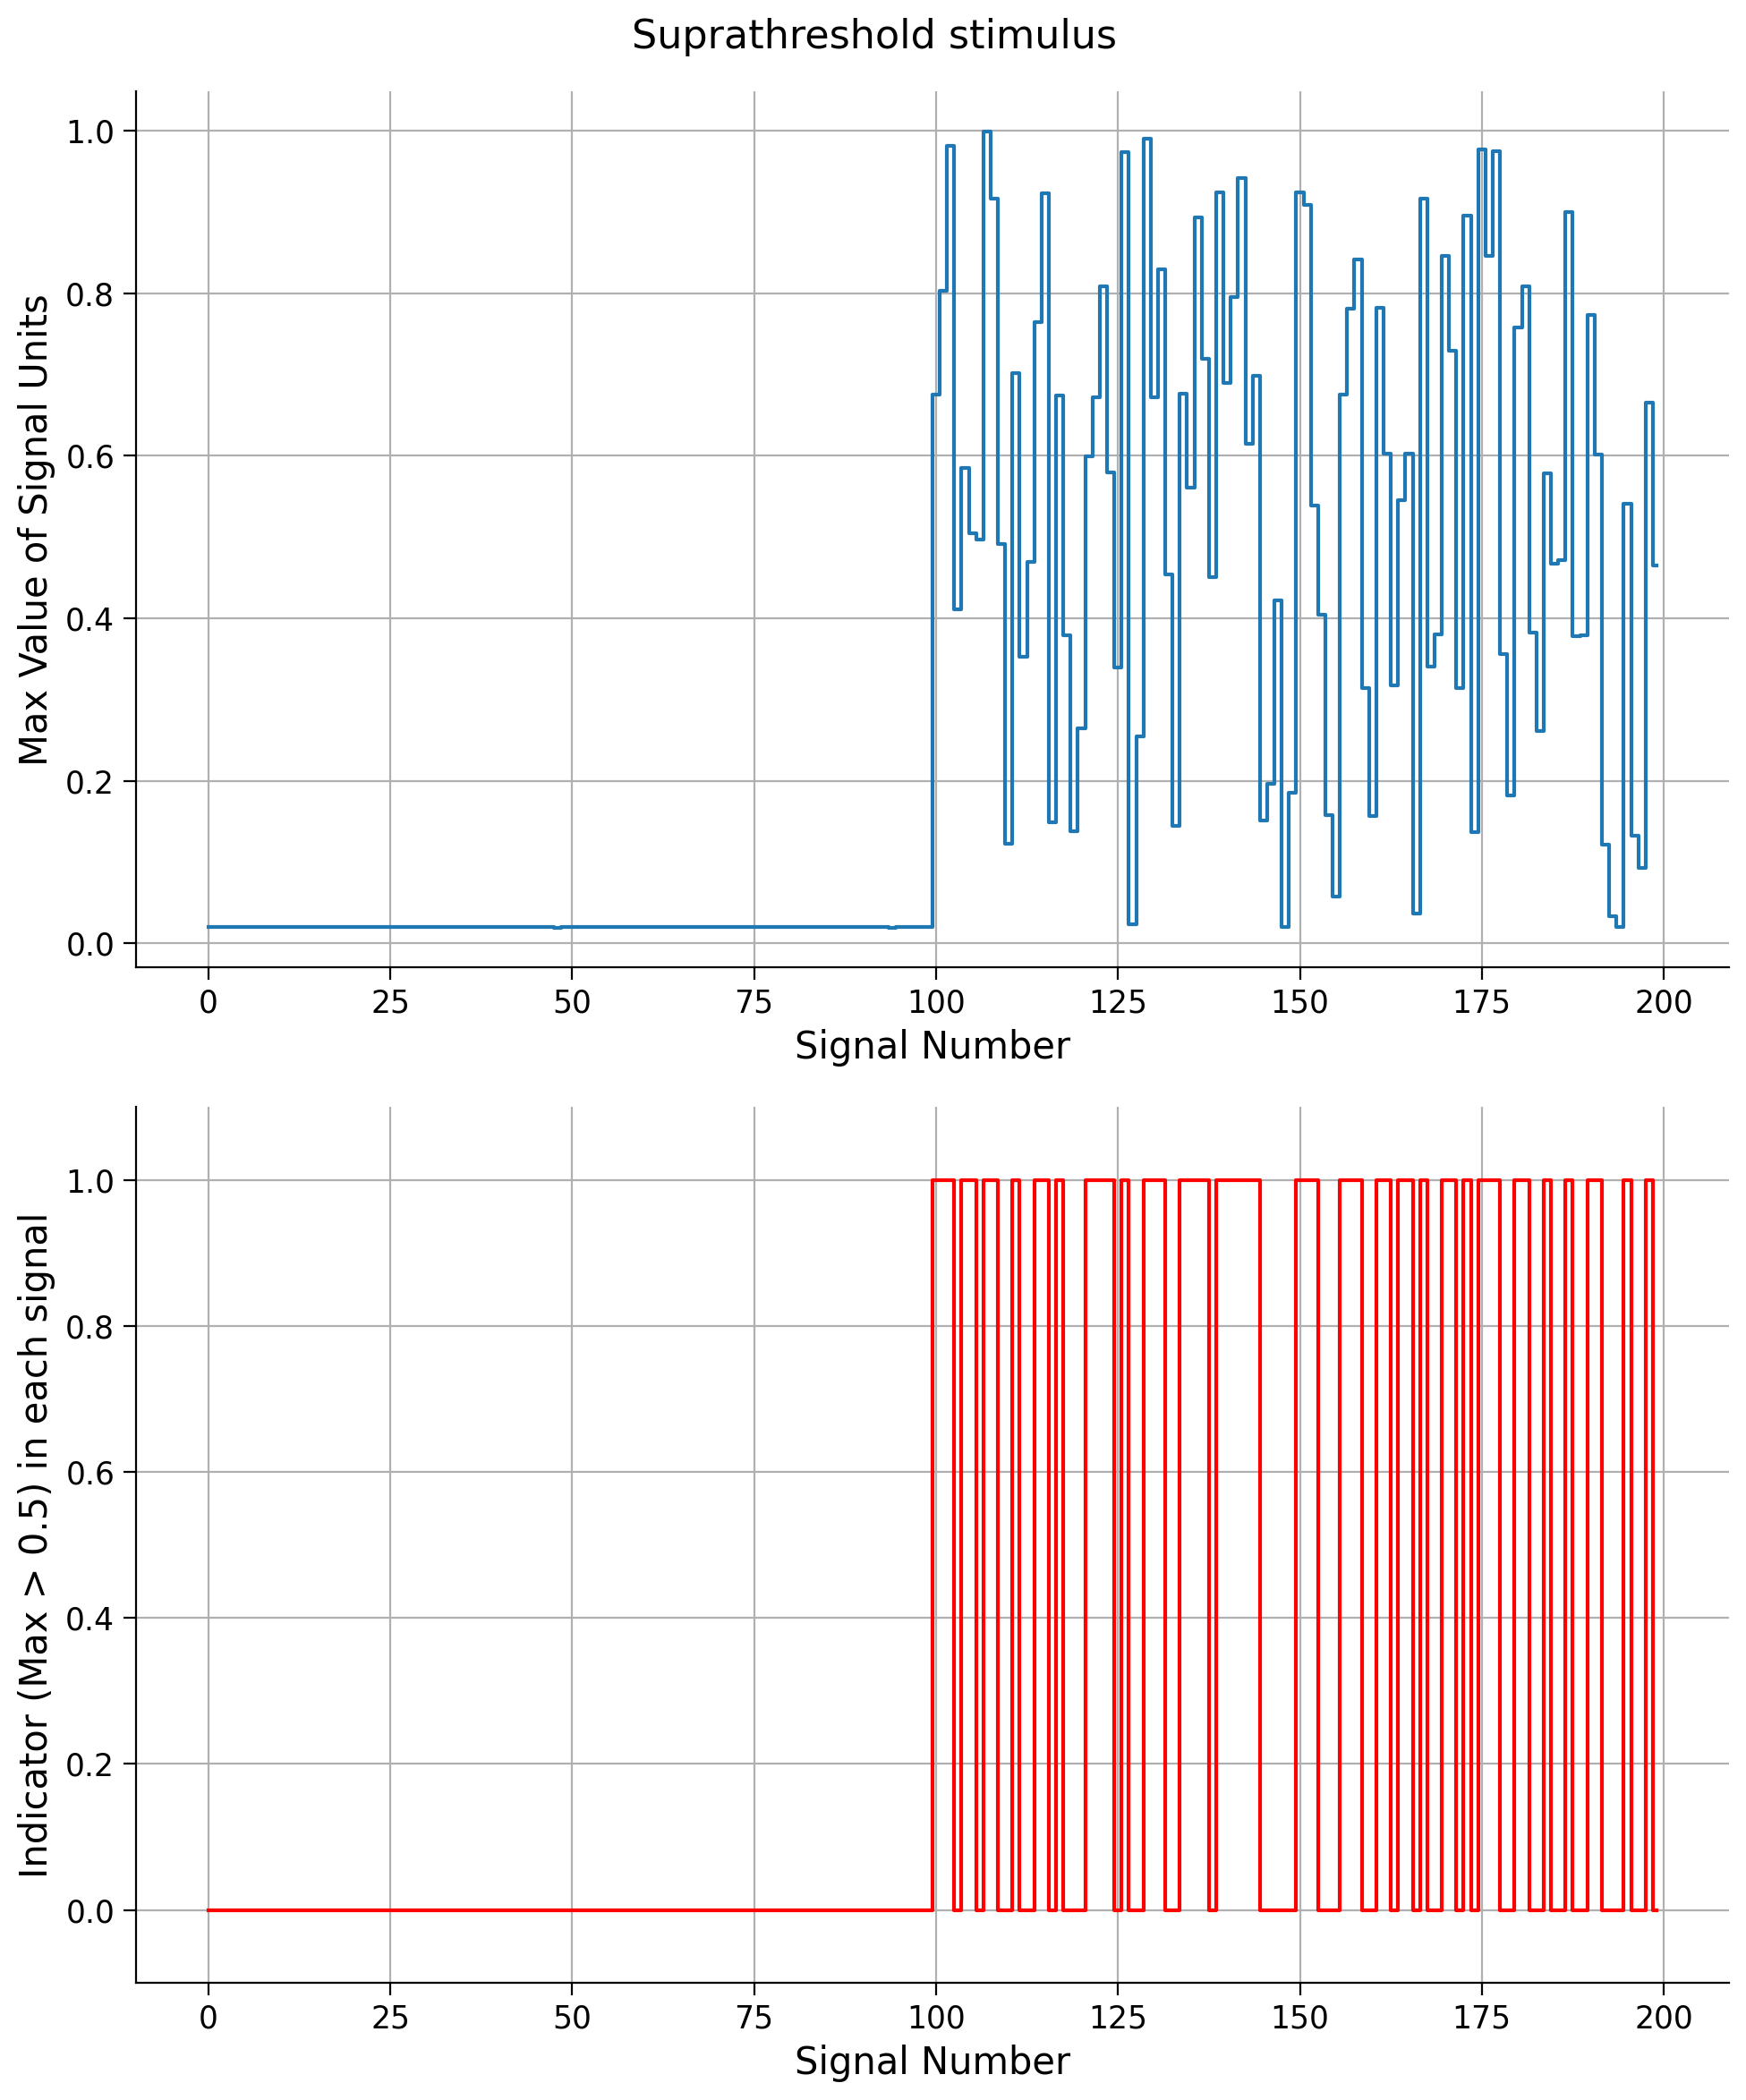

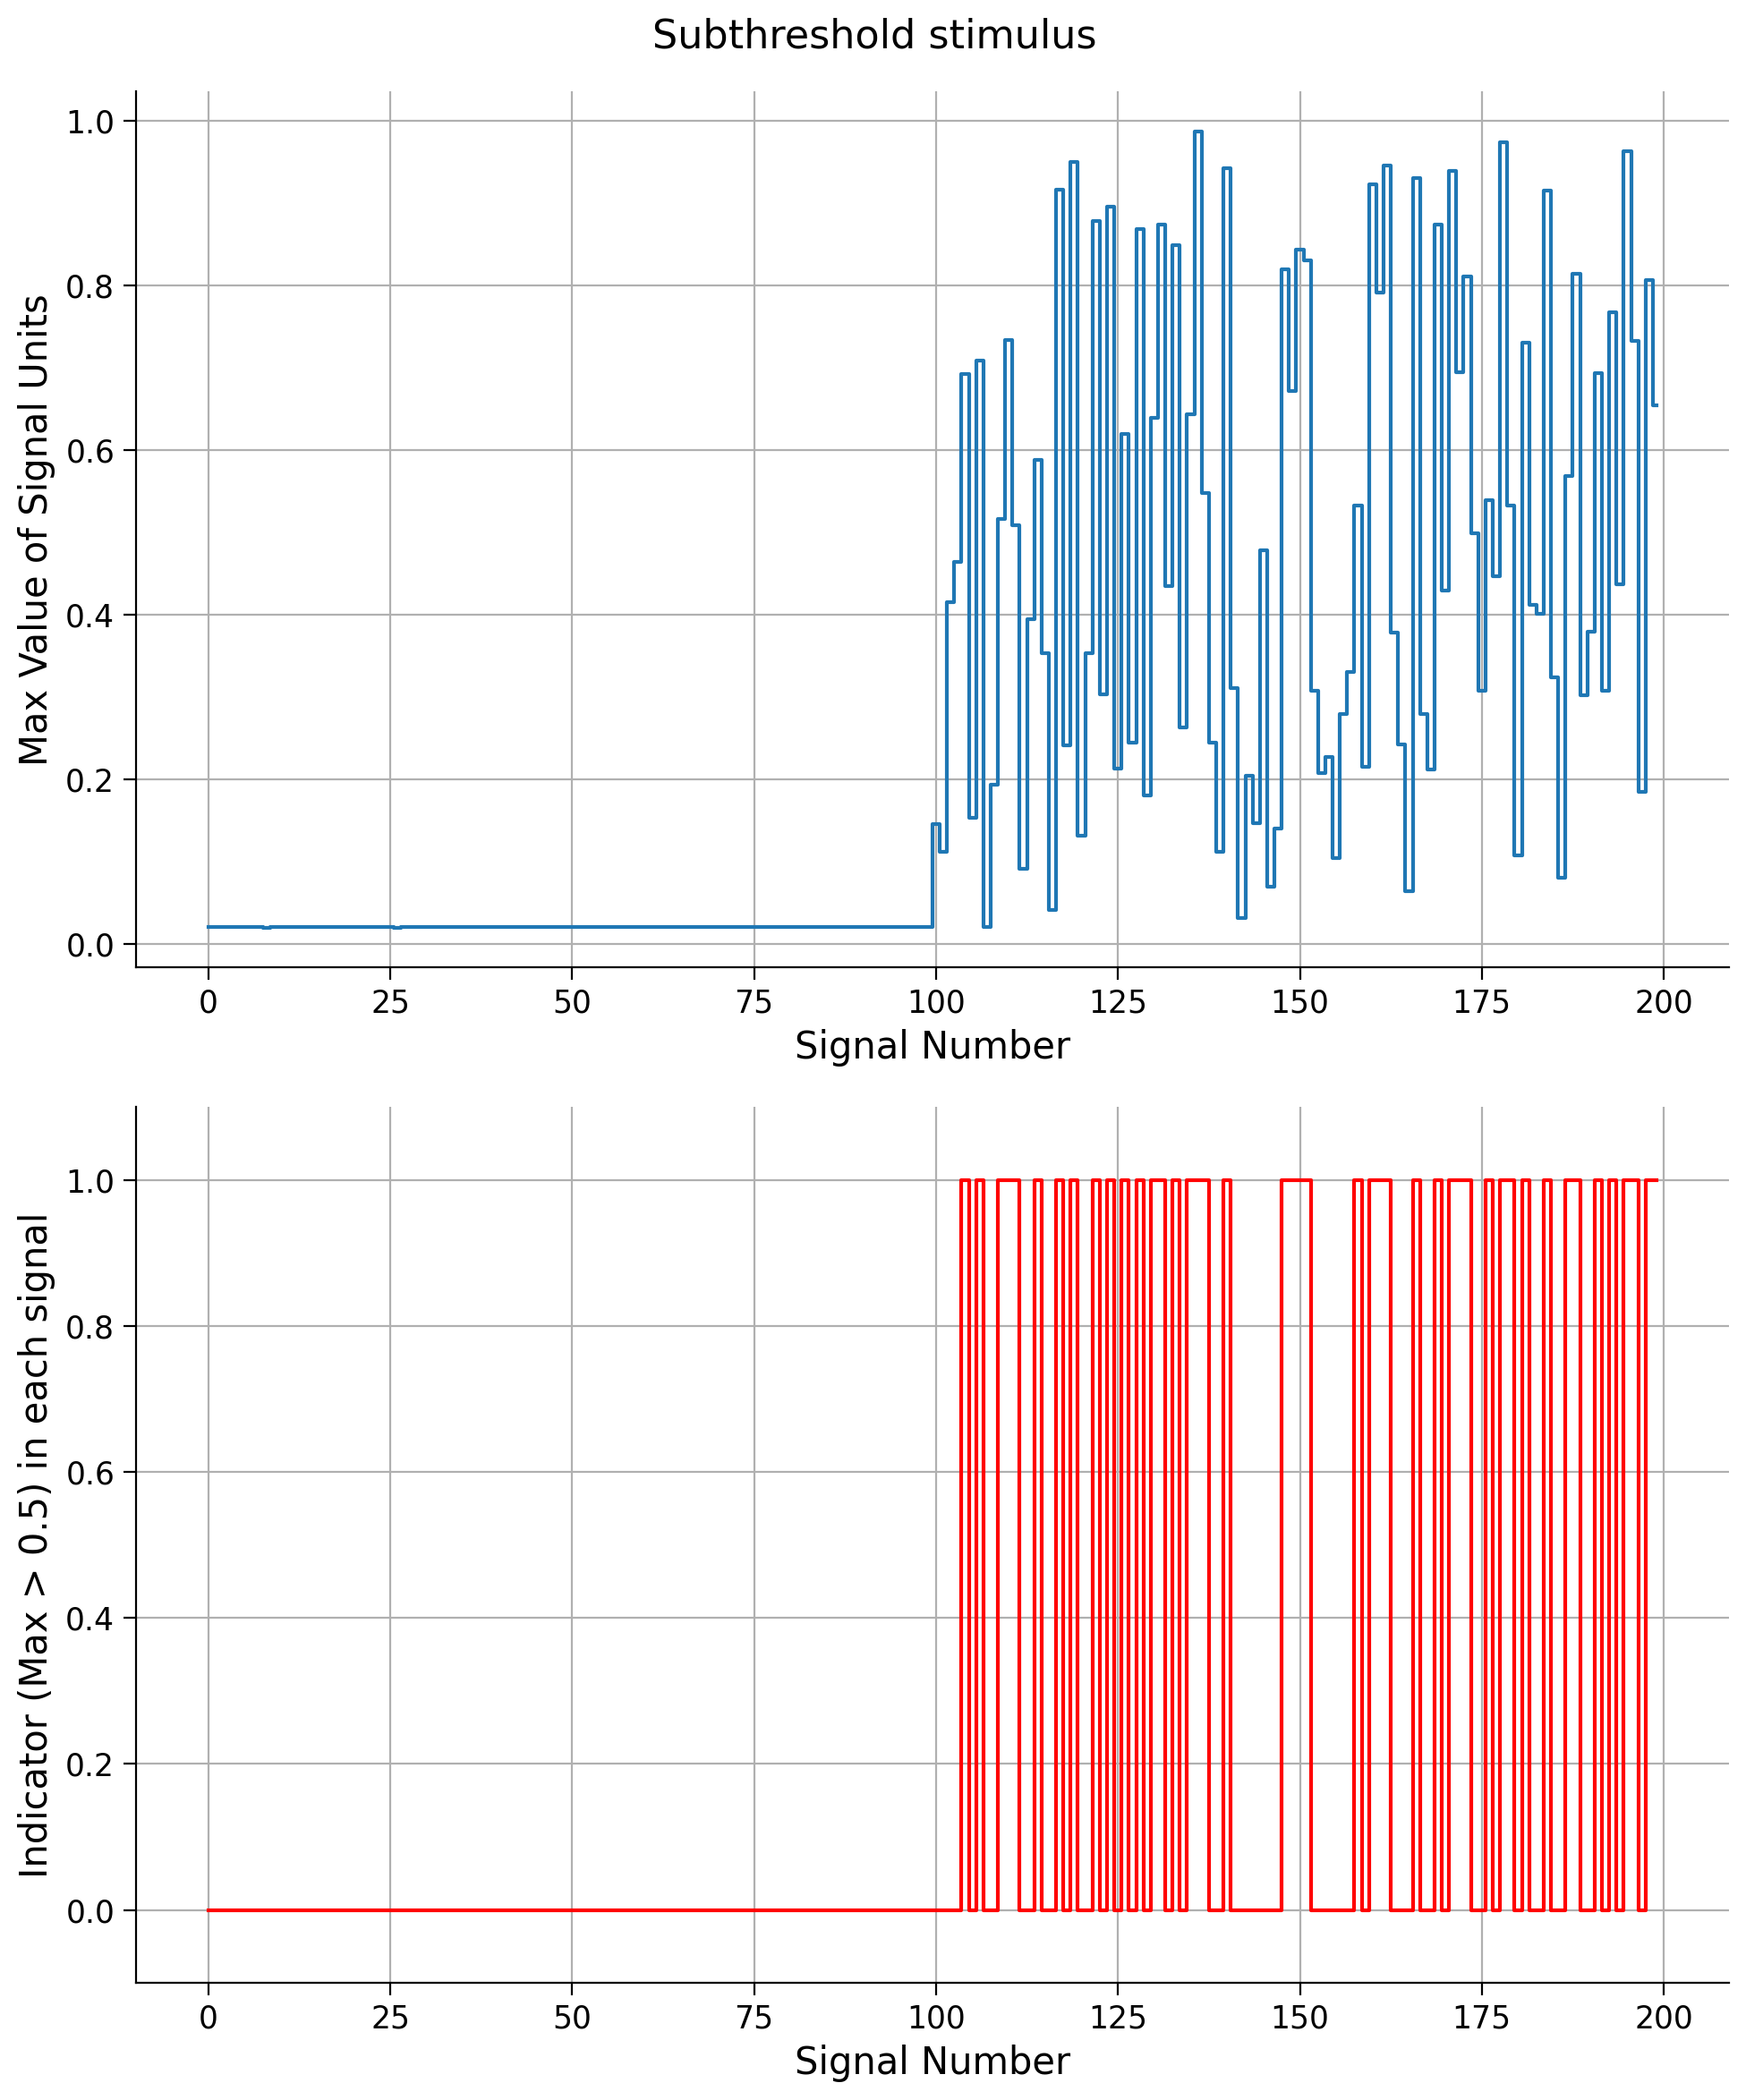

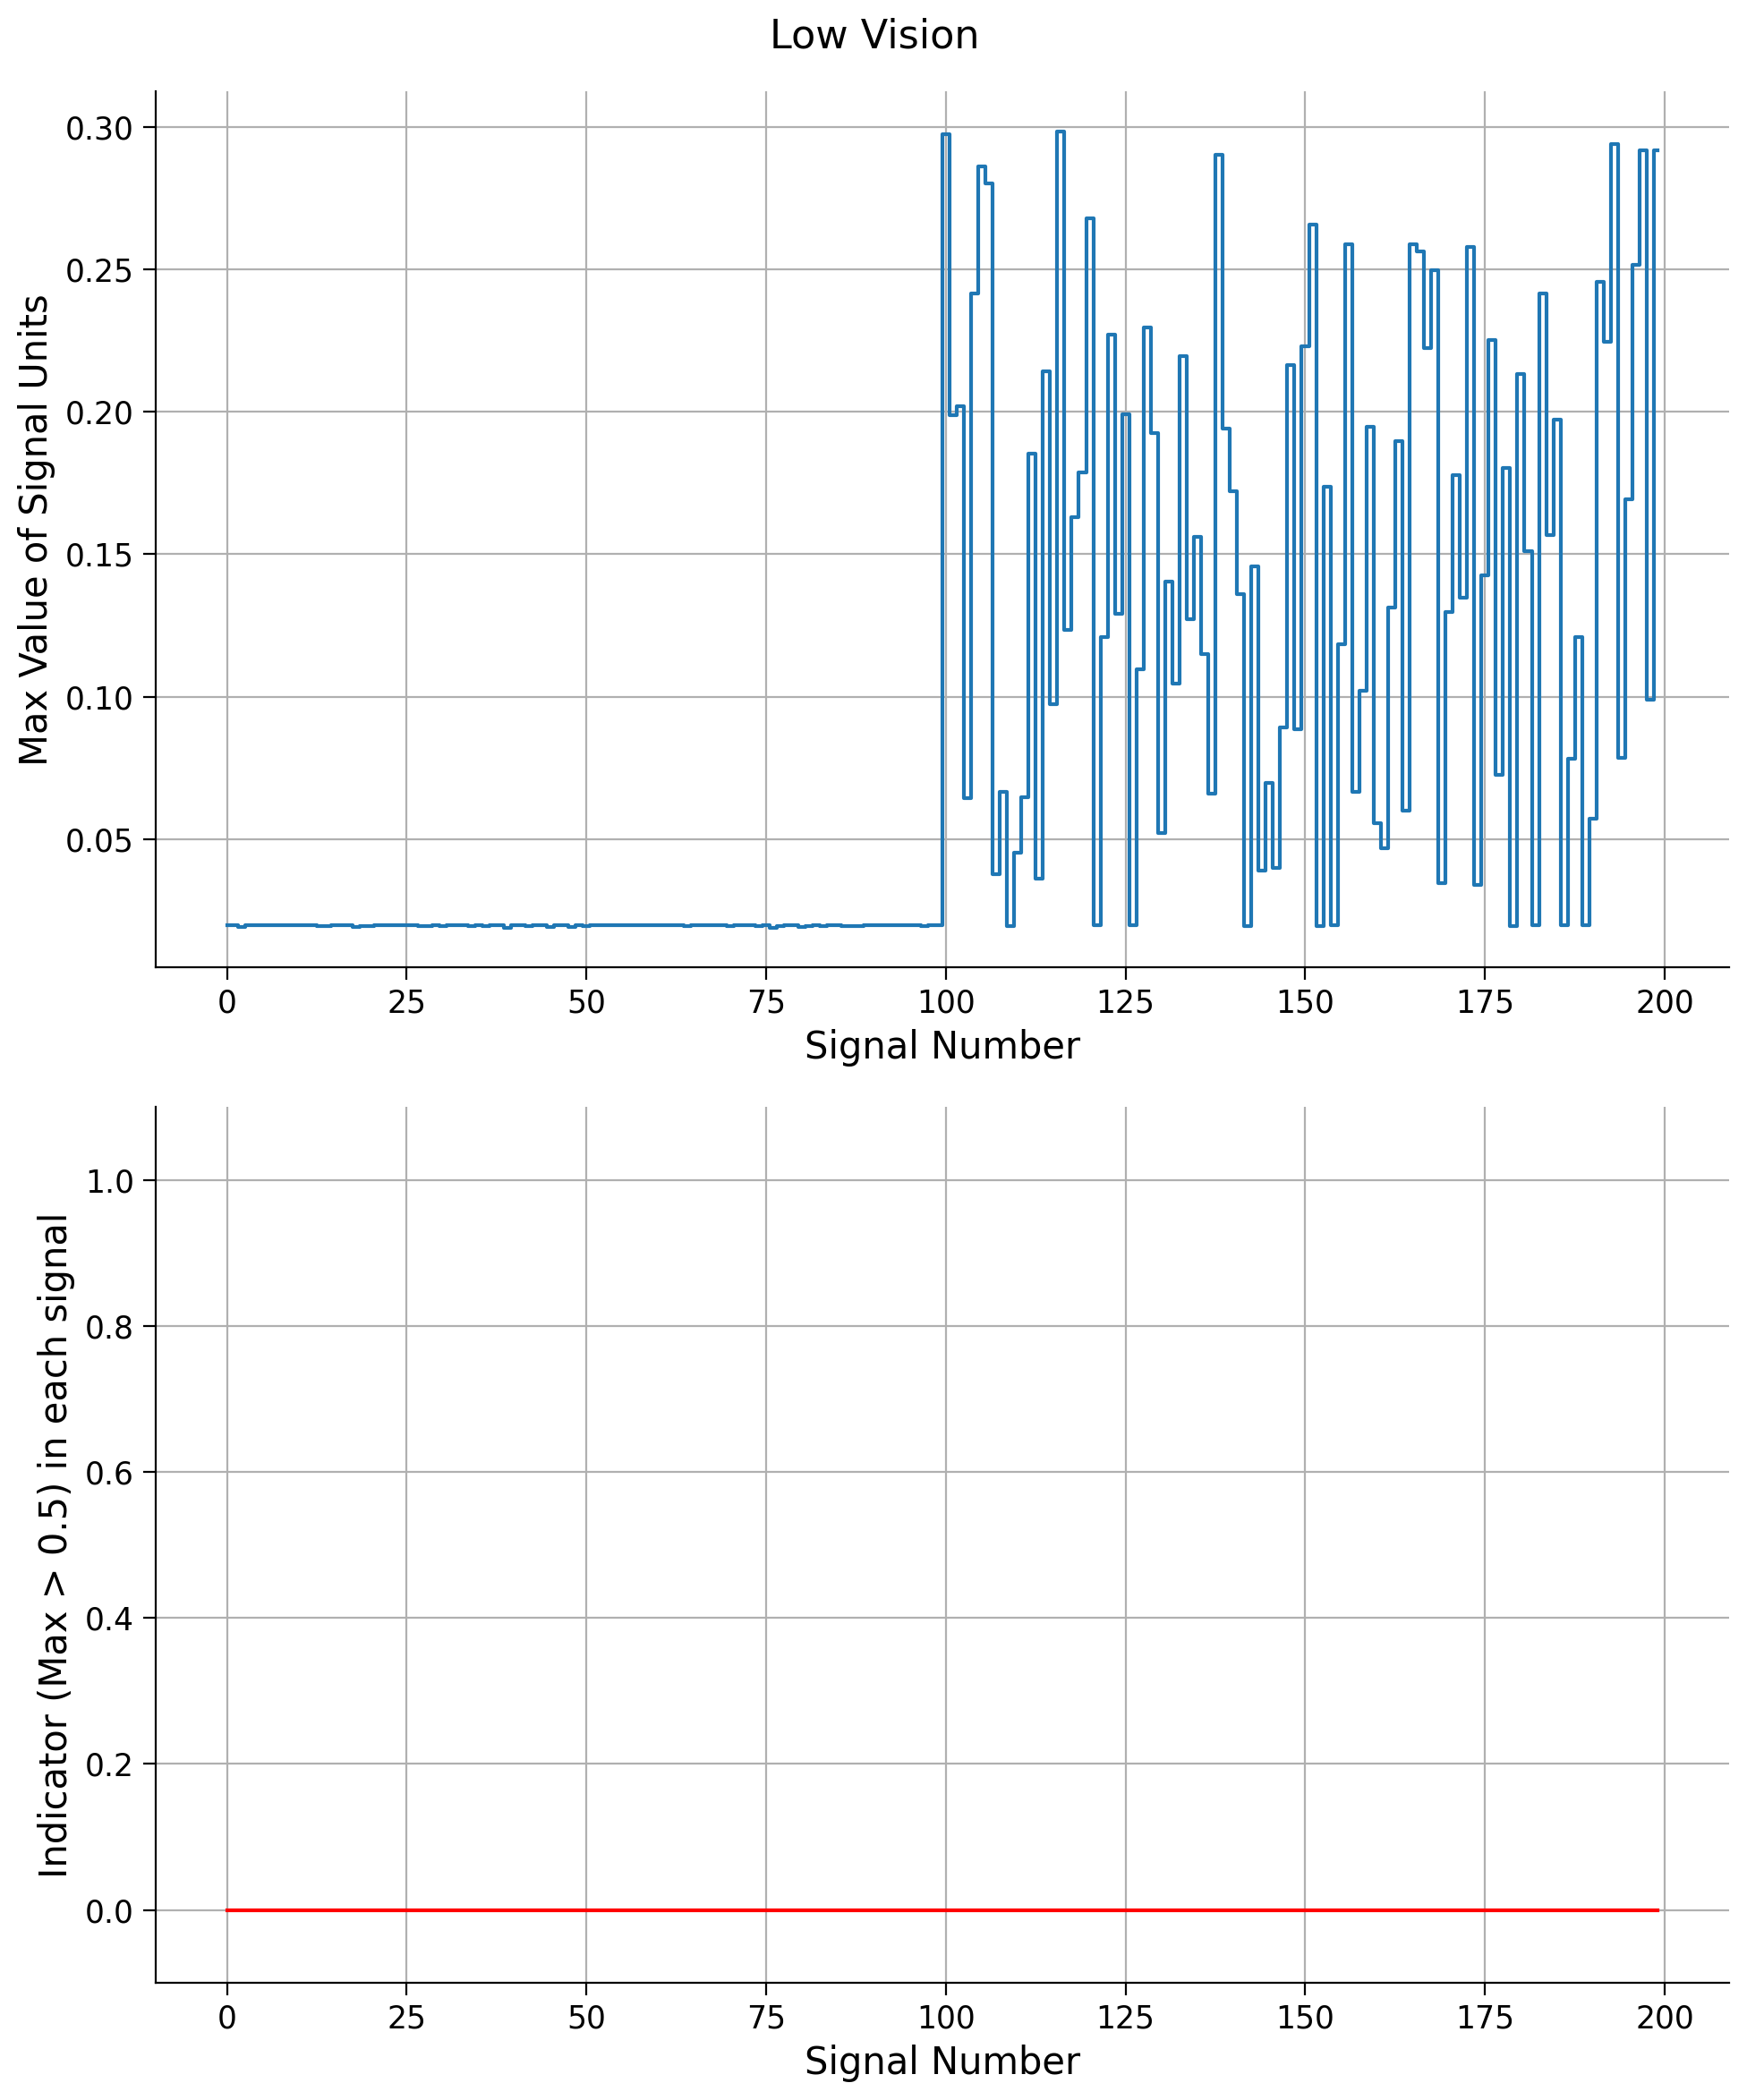

In [22]:
# Compare your results with the patterns generate below
initialize_global()
set_1, _ = create_patterns(0)
set_2, _ = create_patterns(1)
set_3, _ = create_patterns(2)

# Plot
plot_signal_max_and_indicator(set_1,"Suprathreshold stimulus")
plot_signal_max_and_indicator(set_2,"Subthreshold stimulus")
plot_signal_max_and_indicator(set_3,"Low Vision")

The first-order network model lays the groundwork for our experiments and is structured as follows:

- Input layer: consists of 100 units representing either noise or stimulus patterns.
- Hidden layer: includes a 60-unit layer tasked with processing the inputs.
- Output layer: comprises 100 units where the responses to stimuli are recorded.
- Dropout and activation: includes dropout layers to prevent overfitting and a temperature-controlled activation function to fine-tune response sharpness.

The primary aim of the first-order network is to accurately capture and react to the input patterns, setting a baseline for comparison with more complex models.

### Activity 1: Developing a Second-Order Network

Your task is to expand upon the first-order network by integrating a second-order network that incorporates a meta-cognitive layer assessing the predictions of the first-order network. This layer introduces a wagering mechanism, where the network "bets" on its confidence in its predictions, enhancing our understanding of network certainty.

These are the steps for completion:

1. Architectural development: grasp the underlying principles of a second-order network and complete the architectural code.
2. Performance evaluation: visualize training losses and test the model using provided code, assessing its initial performance.
3. Model fine-tuning: leveraging the provided training function, experiment with fine-tuning the model to enhance its accuracy and efficiency.

The second-order network is structured as a feedforward backpropagation network.

- Input layer: comprises a 100-unit comparison matrix. This matrix quantifies the discrepancy between each corresponding pair of input and output units from the first-order network. For example, if an input unit and its corresponding output unit have activations of 0.6 and 0.7, respectively, the comparison unit's activation would be -0.1. This setup essentially encodes the prediction error of the first-order network's outputs as an input pattern for the second-order network.
- Output layer: consists of two units representing "high" and "low" wagers, indicating the network's confidence in its predictions. The initial weights for these output units range between 0.0 and 0.1.
- Comparator weights: set to 1.0 for connections from the first-order input layer to the comparison matrix, and -1.0 for connections from the first-order output layer. This configuration emphasizes the differential error as a critical input for the second-order decision-making process.

The second-order network's novel approach uses the error generated by the first-order network as a direct input for making decisions—specifically, wagering on the confidence of its outputs. This methodology reflects a meta-cognitive layer of processing, akin to evaluating one's confidence in their answers or predictions.

By exploring these adjustments, you can optimize the network's functionality, making it a powerful tool for understanding and simulating complex cognitive phenomena like blindsight.

In [23]:
class SecondOrderNetwork(nn.Module):
    def __init__(self, use_gelu):
        super(SecondOrderNetwork, self).__init__()
        # Define a linear layer for comparing the difference between input and output of the first-order network
        self.comparison_layer = nn.Linear(100, 100)

        # Linear layer for determining wagers, mapping from 100 features to a single output
        self.wager = nn.Linear(100, 1)

        # Dropout layer to prevent overfitting by randomly setting input units to 0 with a probability of 0.3 during training
        self.dropout = nn.Dropout(0.3)

        # Select activation function based on the `use_gelu` flag
        self.activation = torch.nn.GELU() if use_gelu else torch.relu

        # Additional activation functions for potential use in network operations
        self.sigmoid = torch.sigmoid
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax for multi-class classification problems
        self.tanh = torch.tanh

        # Initialize the weights of the network
        self._init_weights()

    def _init_weights(self):
        # Uniformly initialize weights for the comparison and wager layers
        init.uniform_(self.comparison_layer.weight, -1.0, 1.0)
        init.uniform_(self.wager.weight, 0.0, 0.1)

    def forward(self, first_order_input, first_order_output):
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: Calculate the wager value, applying dropout and sigmoid activation to the output of the wager layer")
        ###################################################################
        
        # Calculate the difference between the first-order input and output
        comparison_matrix = first_order_input - first_order_output

        # Pass the difference through the comparison layer and apply the chosen activation function
        comparison_out = self.comparison_layer(comparison_matrix)

        # Calculate the wager value, applying dropout and sigmoid activation to the output of the wager layer
        wager = ...

        return wager

In [24]:
# to_remove solution

class SecondOrderNetwork(nn.Module):
    def __init__(self, use_gelu):
        super(SecondOrderNetwork, self).__init__()
        # Define a linear layer for comparing the difference between input and output of the first-order network
        self.comparison_layer = nn.Linear(100, 100)

        # Linear layer for determining wagers, mapping from 100 features to a single output
        self.wager = nn.Linear(100, 1)

        # Dropout layer to prevent overfitting by randomly setting input units to 0 with a probability of 0.3 during training
        self.dropout = nn.Dropout(0.3)

        # Select activation function based on the `use_gelu` flag
        self.activation = torch.nn.GELU() if use_gelu else torch.relu

        # Additional activation functions for potential use in network operations
        self.sigmoid = torch.sigmoid
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax for multi-class classification problems
        self.tanh = torch.tanh

        # Initialize the weights of the network
        self._init_weights()

    def _init_weights(self):
        # Uniformly initialize weights for the comparison and wager layers
        init.uniform_(self.comparison_layer.weight, -1.0, 1.0)
        init.uniform_(self.wager.weight, 0.0, 0.1)

    def forward(self, first_order_input, first_order_output):
        # Calculate the difference between the first-order input and output
        comparison_matrix = first_order_input - first_order_output

        # Pass the difference through the comparison layer and apply the chosen activation function
        comparison_out = self.comparison_layer(comparison_matrix)

        # Calculate the wager value, applying dropout and sigmoid activation to the output of the wager layer
        wager = self.dropout(self.sigmoid(self.wager(comparison_out)))

        return wager

In [25]:
# Define the architecture, optimizers, loss functions, and schedulers for pre training
hidden=60
factor=1
gelu=False
gam=0.99
stepsize=1

initialize_global()

# First order network instantiation (defined somewhere else)
first_order_network = FirstOrderNetwork(hidden,factor,gelu).to(device)

/home/samuele/virtualenvs/neuroaienv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([200, 2])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


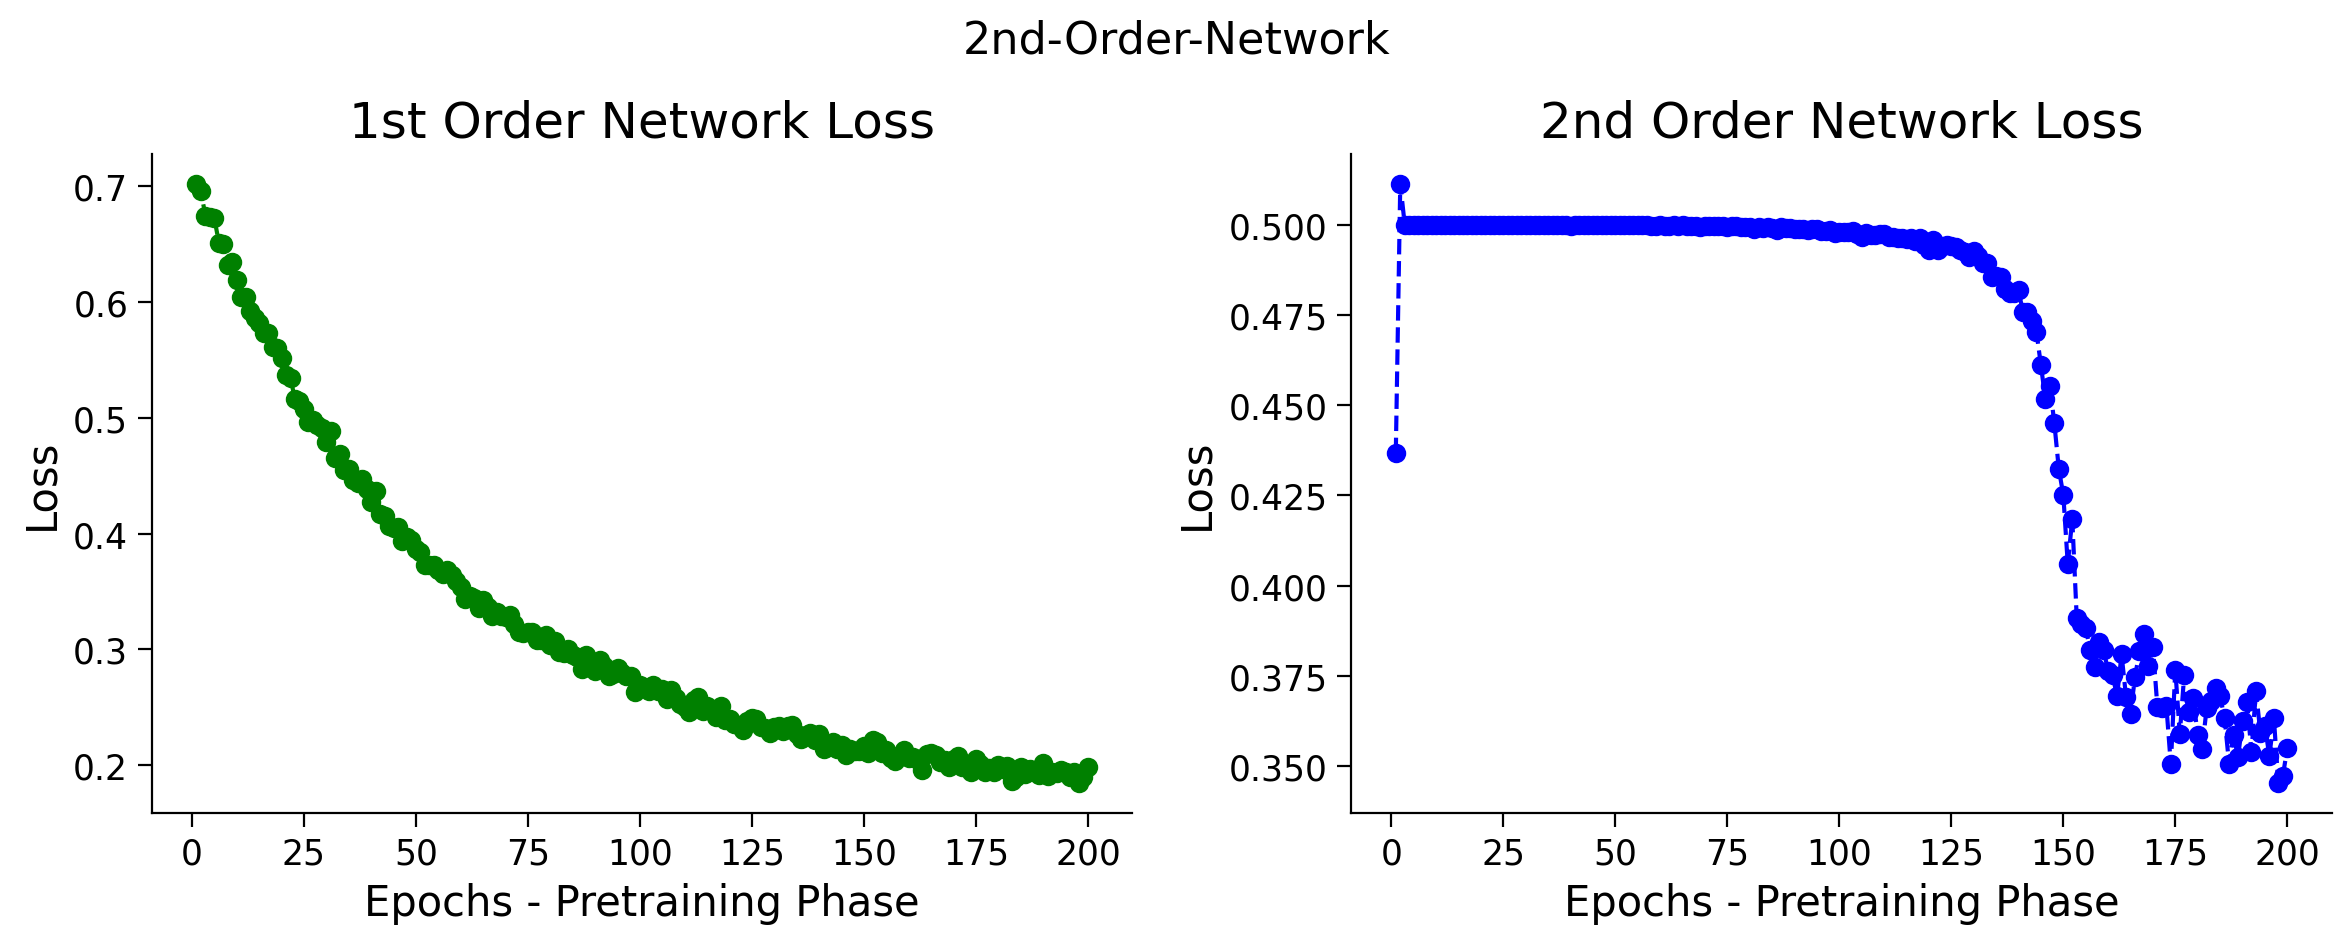

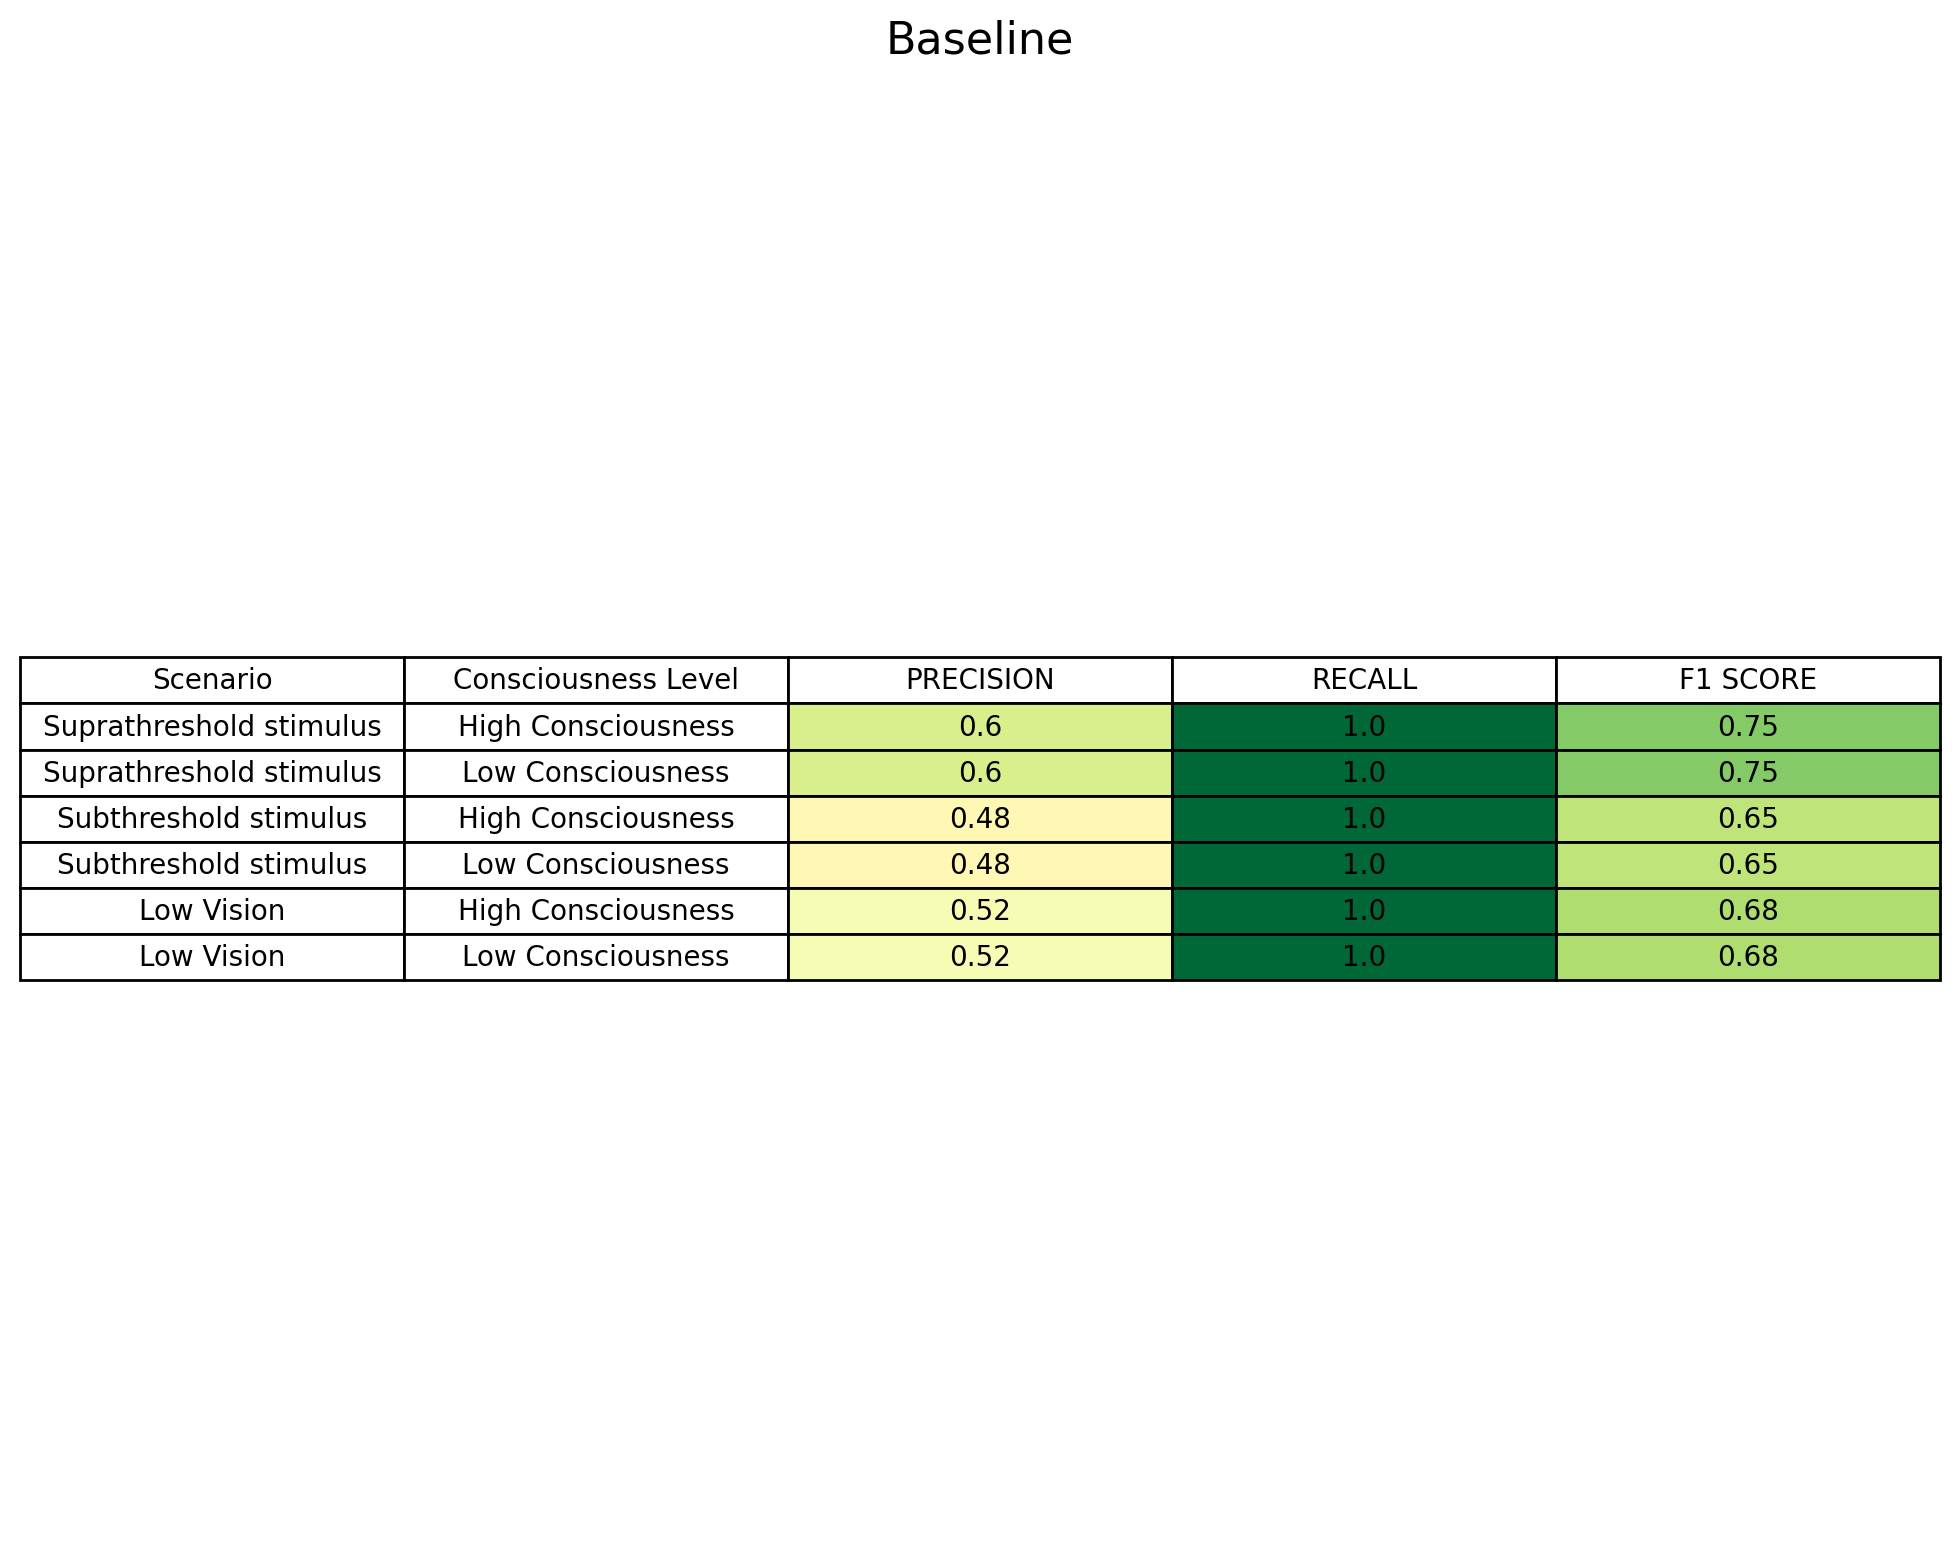

In [26]:
def pre_train(first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, factor, meta):
    """
    Conducts pre-training for first-order and second-order networks.

    Parameters:
    - first_order_network (torch.nn.Module): Network for basic input-output mapping.
    - second_order_network (torch.nn.Module): Network for decision-making based on the first network's output.
    - criterion_1, criterion_2 (torch.nn): Loss functions for the respective networks.
    - optimizer_1, optimizer_2 (torch.optim): Optimizers for the respective networks.
    - scheduler_1, scheduler_2 (torch.optim.lr_scheduler): Schedulers for learning rate adjustment.
    - factor (float): Parameter influencing data augmentation or pattern generation.
    - meta (bool): Flag indicating the use of meta-learning strategies.

    Returns:
    Tuple containing updated networks and epoch-wise loss records.
    """
    for epoch in range(n_epochs):
        # Generate training patterns and targets for each epoch
        patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

        # Forward pass through the first-order network
        output_first_order = first_order_network(patterns_tensor)

        optimizer_1.zero_grad()

        # Conditionally execute the second-order network pass and related operations
        if meta:
            optimizer_2.zero_grad()

            # Forward pass through the second-order network with inputs from the first-order network
            output_second_order = second_order_network(patterns_tensor, output_first_order)

            # Calculate the loss for the second-order network (wagering decision based on comparison)
            loss_2 = criterion_2(output_second_order, order_2_tensor)

            # Backpropagate the second-order network's loss
            loss_2.backward(retain_graph=True)  # Allows further backpropagation for loss_1 after loss_2

            # Update second-order network weights
            optimizer_2.step()

            epoch_2_order[epoch] = loss_2.item()
        else:
            # Skip computations for the second-order network
            with torch.no_grad():
                # Potentially forward pass through the second-order network without tracking gradients
                output_second_order = second_order_network(patterns_tensor, output_first_order)

        # Calculate the loss for the first-order network (accuracy of stimulus representation)
        loss_1 = criterion_1(output_first_order, stim_present_tensor)

        # Backpropagate the first-order network's loss
        loss_1.backward(retain_graph=True)

        # Update first-order network weights
        optimizer_1.step()

        # Reset first-order optimizer gradients to zero for the next iteration

        # Update the first-order scheduler
        scheduler_1.step()

        # Update the second-order scheduler
        scheduler_2.step()

        epoch_1_order[epoch] = loss_1.item()

    return first_order_network, second_order_network, epoch_1_order, epoch_2_order

# Hyperparameters
hidden=60
factor=1
gelu=False
gam=0.99
stepsize=1
meta=True

# Initialize any global variables or settings, potentially for random seed setting or environment setup
initialize_global()

# Prepare networks, loss functions, optimizers, and schedulers for pre-training
first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2 = prepare_pre_training(hidden, factor, gelu, stepsize, gam)

# Conduct pre-training for both the first-order and second-order networks
first_order_network_pre, second_order_network_pre, epoch_1_order, epoch_2_order = pre_train(first_order_network, second_order_network, criterion_1, criterion_2, optimizer_1, optimizer_2, scheduler_1, scheduler_2, factor, meta)

# Plot the training progress of both networks to visualize performance and learning trends
pre_train_plots(epoch_1_order, epoch_2_order, "2nd-Order-Network")

# Configuration step for the main training phase or evaluation
Testing_patterns, n_samples, loaded_model, loaded_model_2 = config_training(first_order_network_pre, second_order_network_pre, hidden, factor, gelu)

# Perform testing of the trained models on a separate dataset to evaluate performance
f1_scores_high_wager, f1_scores_low_wager, results_for_plotting = testing(Testing_patterns, n_samples, loaded_model, loaded_model_2)

# Visualize the testing results, comparing the model performance against a baseline to assess improvements
plot_testing(results_for_plotting, "Baseline")

### Discussion point

Let's dive into the outcomes!

- Did you notice any variations between the two models?
- Can you explain how these differences influenced the performance?
- What role does a second-order network play, and in which situations would it be more effective?

---
## Section 2b: HOSS model

### Video

In [27]:
# @title Video 3

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'BFly8RpKiKk')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In this section, we'll merge ideas from earlier discussions to present a fresh perspective on how conscious awareness might arise in neural systems. This view comes from higher-order theory, which suggests that consciousness stems from the ability to monitor basic, or first-order, information processing activities, instead of merely broadcasting information globally. This concept agrees with global workspace theories that emphasize the need for a comprehensive monitor that oversees various first-order processes. Moreover, it extends the ideas discussed previously about the role of a second-order network, which is crucial for overseeing first-order operations and helps us understand phenomena like blindsight, where a person can respond to visual stimuli without consciously seeing them.

To analyze how our brains handle and update perceptions, we'll operate within a simplified Bayesian framework. This framework helps us evaluate how we perceive reality based on the information we receive. For example, if you hear rustling leaves, your brain calculates the likelihood of it being caused by the wind versus an animal. This calculation involves updating what we initially guess (our prior belief) with new evidence (observed data), resulting in a new, more informed belief (posterior probability).

The function below calculates these updated beliefs and uses Kullback-Leibler (KL) divergence to quantify how much the new information changes our understanding. The KL divergence is a way of measuring the 'distance' between your initial belief and your updated belief. It’s like measuring how much you have to change your mind given new evidence.

We base our analysis on a flat, or single-layer, Bayesian network model. This model directly connects our sensory inputs with our perceptual states, simplifying the complex interactions in our brain into a more manageable form. By stripping away the complexities of multi-layered networks, we focus purely on how direct observations impact our consciousness. This simplified approach helps us to better understand the intricate dance between perception and awareness in our neural systems.

In [28]:
def HOSS_evaluate_flat(X, mu, Sigma, Wprior):
    """
    Perform inference on a 2D Bayes net for asymmetric inference on presence vs. absence.

    Parameters:
    X - Observed data
    mu - Means for each perceptual state
    Sigma - Covariance matrix
    Wprior - Prior probabilities of perceptual states

    #Returns:
    post_W - Posterior probabilities of perceptual states
    KL_W - Kullback-Leibler divergence from posterior to prior
    """
    # Prior on perceptual states W
    p_W = Wprior

    # Compute likelihood of observed X for each possible W (P(X|W))
    log_lik_X_W = np.array([np.log(multivariate_normal.pdf(X, mean=mu[m], cov=Sigma)) for m in range(mu.shape[0])])

    # Renormalize to get P(X|W)
    log_p_X_W = log_lik_X_W - logsumexp(log_lik_X_W)

    # Posterior over W (P(W|X=x))
    log_post_W = log_p_X_W + np.log(p_W)
    log_post_W = log_post_W - logsumexp(log_post_W)  # Normalize
    post_W = np.exp(log_post_W)

    # KL divergences
    KL_W = np.sum(post_W * (np.log(post_W) - np.log(p_W)))

    return post_W, KL_W

### Make our stimulus space

The model we are using is grounded in classical "signal detection theory", or SDT for short. SDT is in turn a special case of a Bayesian generative model, in which an arbitrary "evidence" value is drawn from an unknown distribution, and the task of the observer is to infer which distribution this evidence came from.

Let's give a bit more detail on how SDT fits into the broader framework of Bayesian generative models. In SDT, an observer receives a piece of evidence—this could be any sensory input, like a sound, a light signal, or a statistical data point. The evidence comes from one of several potential distributions. Each distribution represents a different "state of the world." For instance, one distribution might represent the presence of a signal (like a beep), while another might represent just noise. The observer uses Bayesian inference to assess the probability that the received evidence came from one distribution or another. This involves updating their beliefs (probabilities) based on the new evidence. Based on the probabilities calculated through Bayesian inference, the observer decides which distribution most likely produced the evidence.

Let's now imagine we have two categories, A and B - for instance, left- and right-tilted visual stimuli. The sensory "evidence" can be written as 2D vector, where the first element is evidence for A, and the second element evidence for B:

In [29]:
# Creating the array X with strong evidence for A and weak evidence for B
X = np.array([1.5, 0])

The origin (0,0) represents low activation of both features, consistent with no stimulus (or noise) being presented. Comparing how the model handles inference on stimulus presence vs. absence - detecting, vs. not detecting a stimulus - allows us to capture the classical conscious vs. unconscious contrast in consciousness science.

Let's start by creating our space, and placing three Gaussian distributions on the space that represent the likelihood of observing a pair of features given each of three stimulus classes: leftward tilt (w1), rightward tilt (w2) and noise/nothing (w0). By setting up this model, we aim to simulate and analyze how an observer infers the presence or absence of a stimulus. When the observer detects a stimulus, the inference process would lean towards either the leftward or rightward tilt, depending on which Gaussian (w1 or w2) the observed data points are closer to in feature space. When the observer fails to detect a stimulus, the inference process would recognize that the data points fall closer to the noise distribution centered at the origin.

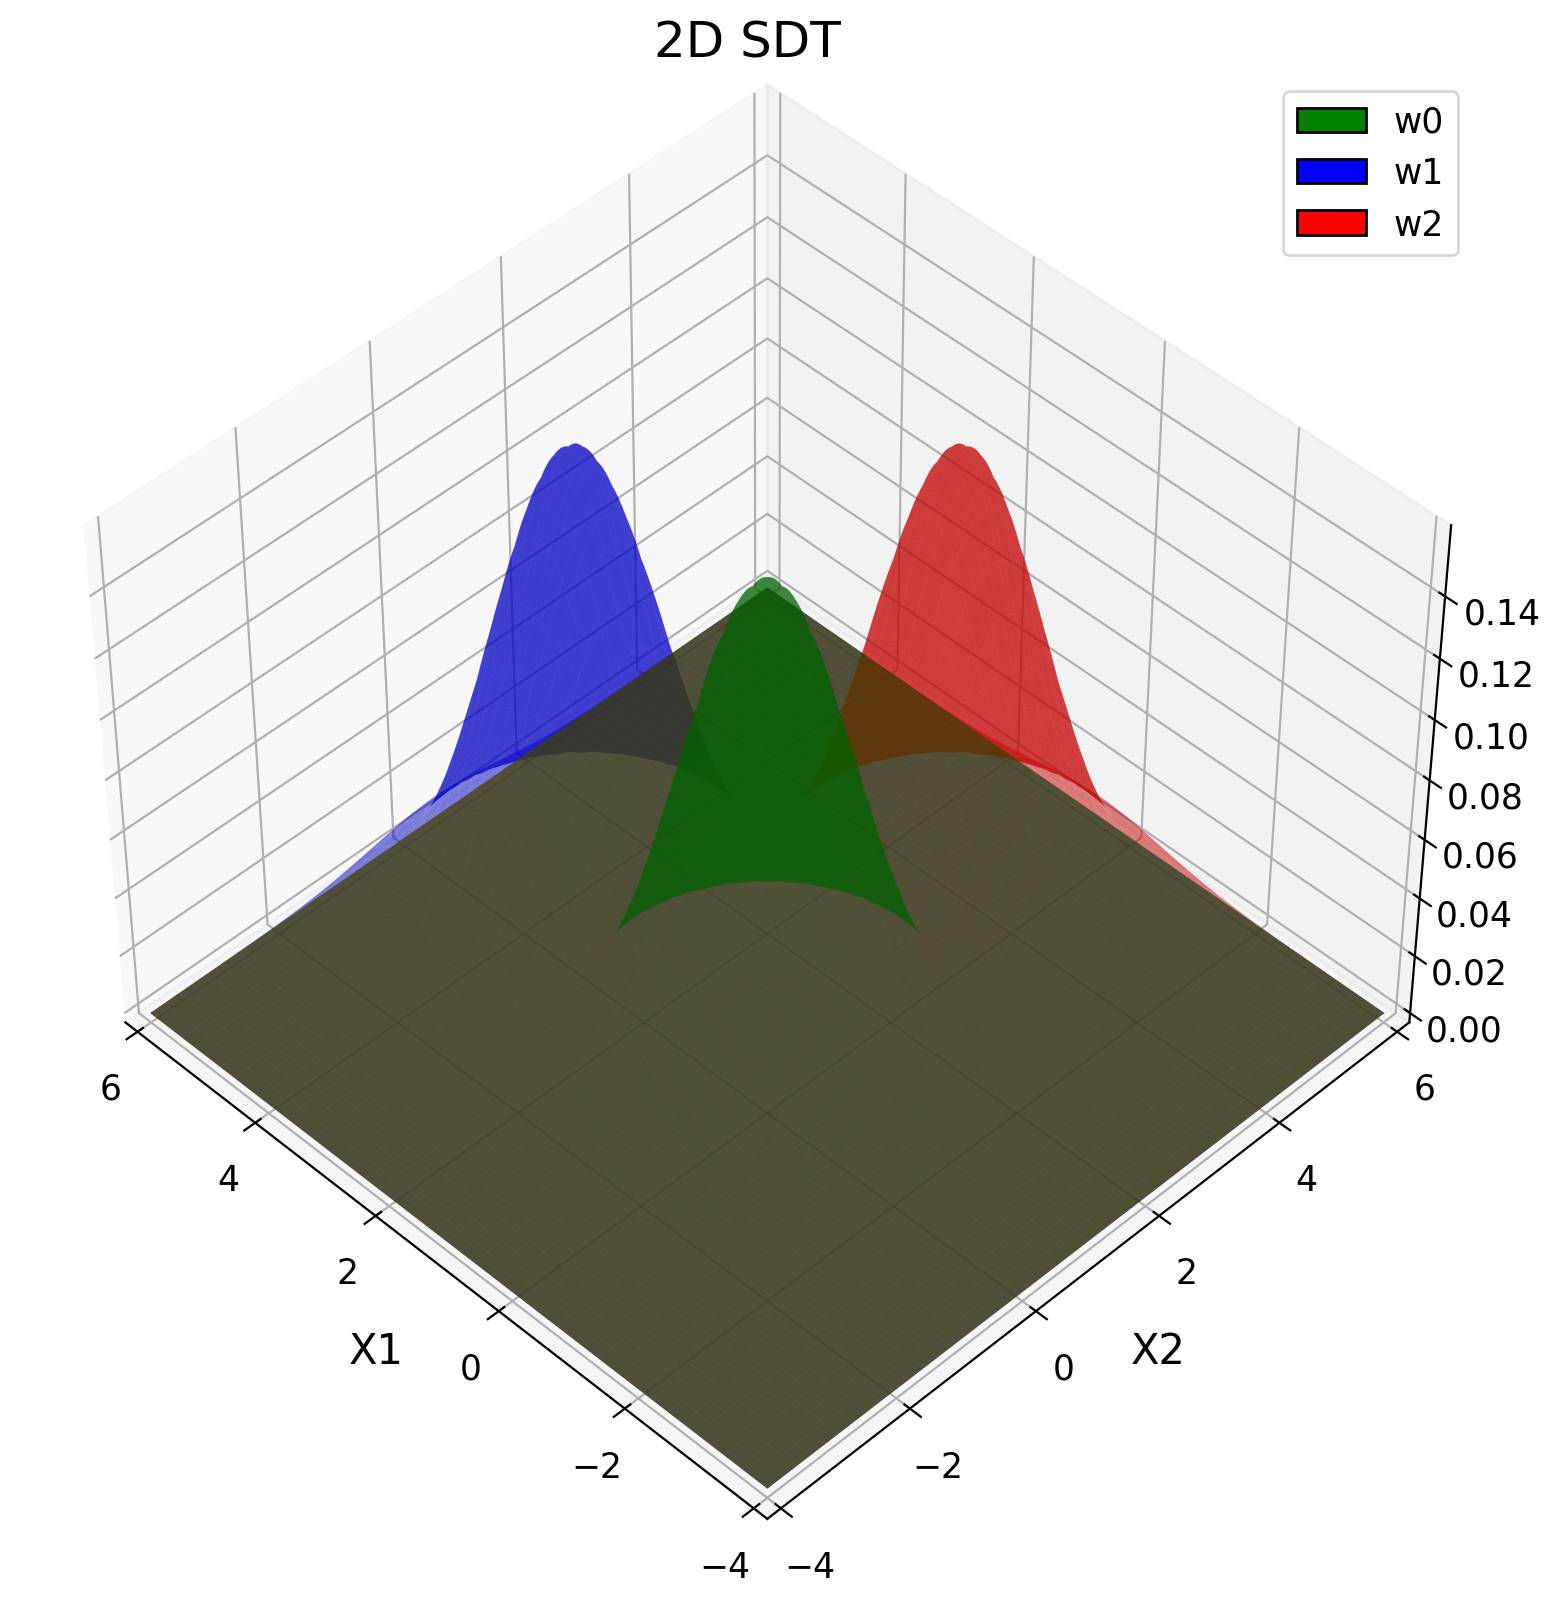

In [30]:
# Define the grid
xgrid = np.arange(-4, 6.02, 0.02)
X1, X2 = np.meshgrid(xgrid, xgrid)

# Mean and covariance of the distributions
mu = np.array([[0.5, 0.5], [3.5, 0.5], [0.5, 3.5]])
Sigma = np.array([[1, 0], [0, 1]])

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Colors and labels according to the specification
colors = ['green', 'blue', 'red']
labels = ['w0', 'w1', 'w2']

for i, (color, label) in enumerate(zip(colors, labels)):
    p = multivariate_normal.pdf(np.dstack((X1, X2)), mean=mu[i], cov=Sigma)
    ax.plot_surface(X1, X2, p.reshape(X1.shape), color=color, alpha=0.5, label=label)

# Create custom legends
legend_elements = [Patch(facecolor=color, edgecolor='k', label=label) for color, label in zip(colors, labels)]
ax.legend(handles=legend_elements, loc='upper right')

# Reverse the X1 axis
ax.set_xlim([6, -4])
ax.set_ylim([-4, 6])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('2D SDT')
ax.view_init(45, -45)

plt.show()

In [31]:
# Define the input parameters
mu = np.array([[3.5, 0.5], [0.5, 3.5], [0.5, 0.5]])
Sigma = np.array([[1, 0], [0, 1]])
Wprior = np.array([1/3, 1/3, 1/3])  # flat priors

# High evidence for X1, low evidence for X2
X = np.array([3, 0])
post_w, KL_W = HOSS_evaluate_flat(X, mu, Sigma, Wprior)
print('Posterior probabilities for X = [3, 0]:', post_w)
print('KL Divergence for X = [3, 0]:', KL_W)

# High evidence for X2, low evidence for X1
X = np.array([0, 3])
post_w, KL_W = HOSS_evaluate_flat(X, mu, Sigma, Wprior)
print('Posterior probabilities for X = [0, 3]:', post_w)
print('KL Divergence for X = [0, 3]:', KL_W)

# No evidence for either
X = np.array([0, 0])
post_w, KL_W = HOSS_evaluate_flat(X, mu, Sigma, Wprior)
print('Posterior probabilities for X = [0, 0]:', post_w)
print('KL Divergence for X = [0, 0]:', KL_W)

Posterior probabilities for X = [3, 0]: [9.52462158e-01 1.17543168e-04 4.74202986e-02]
KL Divergence for X = [3, 0]: 0.9065886027316271
Posterior probabilities for X = [0, 3]: [1.17543168e-04 9.52462158e-01 4.74202986e-02]
KL Divergence for X = [0, 3]: 0.9065886027316271
Posterior probabilities for X = [0, 0]: [0.00246652 0.00246652 0.99506695]
KL Divergence for X = [0, 0]: 1.0640687398203204


This is as we would expect - the most likely state is recovered in each case. The slightly higher KL divergence in the third scenario indicates a greater degree of "surprise" or information gain, as the prior was uniformly distributed across all states, but the posterior is now highly concentrated on the third state.

### Add in higher-order node for global detection

So far, our model has been straightforward, or "flat," where each perceptual state (like leftward tilt, rightward tilt, or no stimulus) is treated separately. However, real-life perception often requires more complex judgments about the presence or absence of any stimulus, not just identifying specific types. This is where a higher-order node comes into play.

#### Introducing the "A" Level:

Think of the "A" level as a kind of overseer or monitor that watches over the lower-level states (w1, w2, etc.). This higher-order node isn't concerned with the specific content of the stimulus (like which direction something is tilting) but rather with whether there's any significant stimulus at all versus just noise. It takes inputs from the same data (pairs of X's), but it adds a layer of awareness. It evaluates whether the data points suggest any meaningful content or if they're likely just random noise. The system can now answer questions on two levels—about the content (W-level) and about the awareness or presence of any content (A-level). The output from the A-level, denoted as `post_A`, represents the posterior probability that there is any relevant content as opposed to mere noise. To make this work, we also need to set priors (initial guesses before seeing the data) at both the W-level (content) and A-level (awareness). This helps the model start with a baseline expectation about the likelihood of encountering various stimuli or noise.

By introducing this higher-order node, our model gains several advantages:

- **Flexibility in awareness**: the A-level allows the system to flexibly determine the overall presence of any stimulus across a variety of conditions, enhancing the model's ability to deal with complex, real-world sensory environments.
  
- **Enhanced information processing**: with the higher-order state, the model doesn't just react to sensory inputs; it evaluates them. This means it can more effectively determine which sensory data are reliable and should be used for further processing and which should be disregarded as noise.
  
- **Improved efficiency**: the higher-order monitoring makes the system more efficient. It can prevent unnecessary processing of irrelevant information and focus computational resources on processing significant, reliable stimuli.

In the next sections, we will illustrate the operation of a higher-order state space (HOSS) for monitoring first-order information processing. This model, with its higher-order node, more closely mimics human perceptual processing where not every sensory input leads to awareness. It only brings to consciousness those inputs that are deemed significant through this higher-level evaluation. This higher-order state has a wide purview, enabling the system to “know” which of its (potentially high-dimensional, rich) first-order states are reliable enough for use in future computation and communication to others. Through this mechanism, the HOSS model not only enhances the accuracy of stimulus awareness but also significantly improves the system's efficiency in processing and utilizing information.

### Coding exercise

In [32]:
def HOSS_evaluate(X, mu, Sigma, Aprior, Wprior):
    """
    Inference on 2D Bayes net for asymmetric inference on presence vs. absence.
    """

    #################################################
    ## TODO for students: fill in the missing variables ##
    # Fill out function and remove
    raise NotImplementedError("Student exercise: fill in the missing variables")
    #################################################

    # Initialise variables and conditional prob tables
    p_A = np.array([1 - Aprior, Aprior])  # prior on awareness state A
    p_W_a1 = np.append(Wprior, 0)  # likelihood of world states W given aware, last entry is absence
    p_W_a0 = np.append(np.zeros(len(Wprior)), 1)  # likelihood of world states W given unaware, last entry is absence
    p_W = (p_W_a1 + p_W_a0) / 2  # prior on W marginalising over A (for KL)

    # Compute likelihood of observed X for each possible W (P(X|mu_w, Sigma))
    lik_X_W = np.array([multivariate_normal.pdf(...) for mu_i in mu])
    p_X_W = lik_X_W / lik_X_W.sum()  # normalise to get P(X|W)

    # Combine with likelihood of each world state w given awareness state A
    lik_W_A = np.vstack((p_X_W * p_W_a0 * p_A[0], p_X_W * p_W_a1 * p_A[1]))
    post_A = ...  # sum over W
    post_A = post_A / post_A.sum()  # normalise

    # Posterior over W (P(W|X=x) marginalising over A)
    post_W = ...  # sum over A
    post_W = post_W / post_W.sum()  # normalise

    # KL divergences
    KL_W = (post_W * np.log(post_W / p_W)).sum()
    KL_A = (post_A * np.log(post_A / p_A)).sum()

    return post_W, post_A, KL_W, KL_A

In [33]:
# to_remove solution

def HOSS_evaluate(X, mu, Sigma, Aprior, Wprior):
    """
    Inference on 2D Bayes net for asymmetric inference on presence vs. absence.
    """

    # Initialise variables and conditional prob tables
    p_A = np.array([1 - Aprior, Aprior])  # prior on awareness state A
    p_W_a1 = np.append(Wprior, 0)  # likelihood of world states W given aware, last entry is absence
    p_W_a0 = np.append(np.zeros(len(Wprior)), 1)  # likelihood of world states W given unaware, last entry is absence
    p_W = (p_W_a1 + p_W_a0) / 2  # prior on W marginalising over A (for KL)

    # Compute likelihood of observed X for each possible W (P(X|mu_w, Sigma))
    lik_X_W = np.array([multivariate_normal.pdf(X, mean=mu_i, cov=Sigma) for mu_i in mu])
    p_X_W = lik_X_W / lik_X_W.sum()  # normalise to get P(X|W)

    # Combine with likelihood of each world state w given awareness state A
    lik_W_A = np.vstack((p_X_W * p_W_a0 * p_A[0], p_X_W * p_W_a1 * p_A[1]))
    post_A = lik_W_A.sum(axis=1)  # sum over W
    post_A = post_A / post_A.sum()  # normalise

    # Posterior over W (P(W|X=x) marginalising over A)
    post_W = lik_W_A.sum(axis=0)  # sum over A
    post_W = post_W / post_W.sum()  # normalise

    # KL divergences
    KL_W = (post_W * np.log(post_W / p_W)).sum()
    KL_A = (post_A * np.log(post_A / p_A)).sum()

    return post_W, post_A, KL_W, KL_A

This is now factorised in the code, so we first set the prior on presence (vs. absence), and then set the priors on w1 vs. w2, and the model takes care of the rest. 

In [34]:
# Define the input parameters for this specific example
X = np.array([0, 3])  # Input observed features
Wprior = np.array([0.5, 0.5])  # Prior probabilities of stimuli
Aprior = 0.5  # Prior probability of being aware

# Call the HOSS_evaluate function with the specified parameters
post_W, post_A, KL_W, KL_A = HOSS_evaluate(X, mu, Sigma, Aprior, Wprior)

# Print the posterior probabilities
print(f"Posterior probabilities at W level: {post_W}")
print(f"Posterior probability at A level: {post_A}")

Posterior probabilities at W level: [1.12221587e-04 9.09340939e-01 9.05468390e-02]
Posterior probability at A level: [0.09054684 0.90945316]


In [35]:
# Define the input parameters for this specific example
X = np.array([0, 3])  # Input observed features
Wprior = np.array([0.5, 0.5])  # Prior probabilities of stimuli
Aprior = 0.5  # Prior probability of being aware

# Call the HOSS_evaluate function with the specified parameters
post_W, post_A, KL_W, KL_A = HOSS_evaluate(X, mu, Sigma, Aprior, Wprior)

# Print the posterior probabilities
print(f"Posterior probabilities at W level: {post_W}")
print(f"Posterior probability at A level: {post_A}")

Posterior probabilities at W level: [1.12221587e-04 9.09340939e-01 9.05468390e-02]
Posterior probability at A level: [0.09054684 0.90945316]


### Simulate KL divergence surfaces

We can also simulate K-L divergences (a measure of Bayesian surprise) at each layer in the network, which under predictive coding models of brain has been proposed to scale with neural activation (eg Friston, 2005; Summerfield & de Lange, 2014).

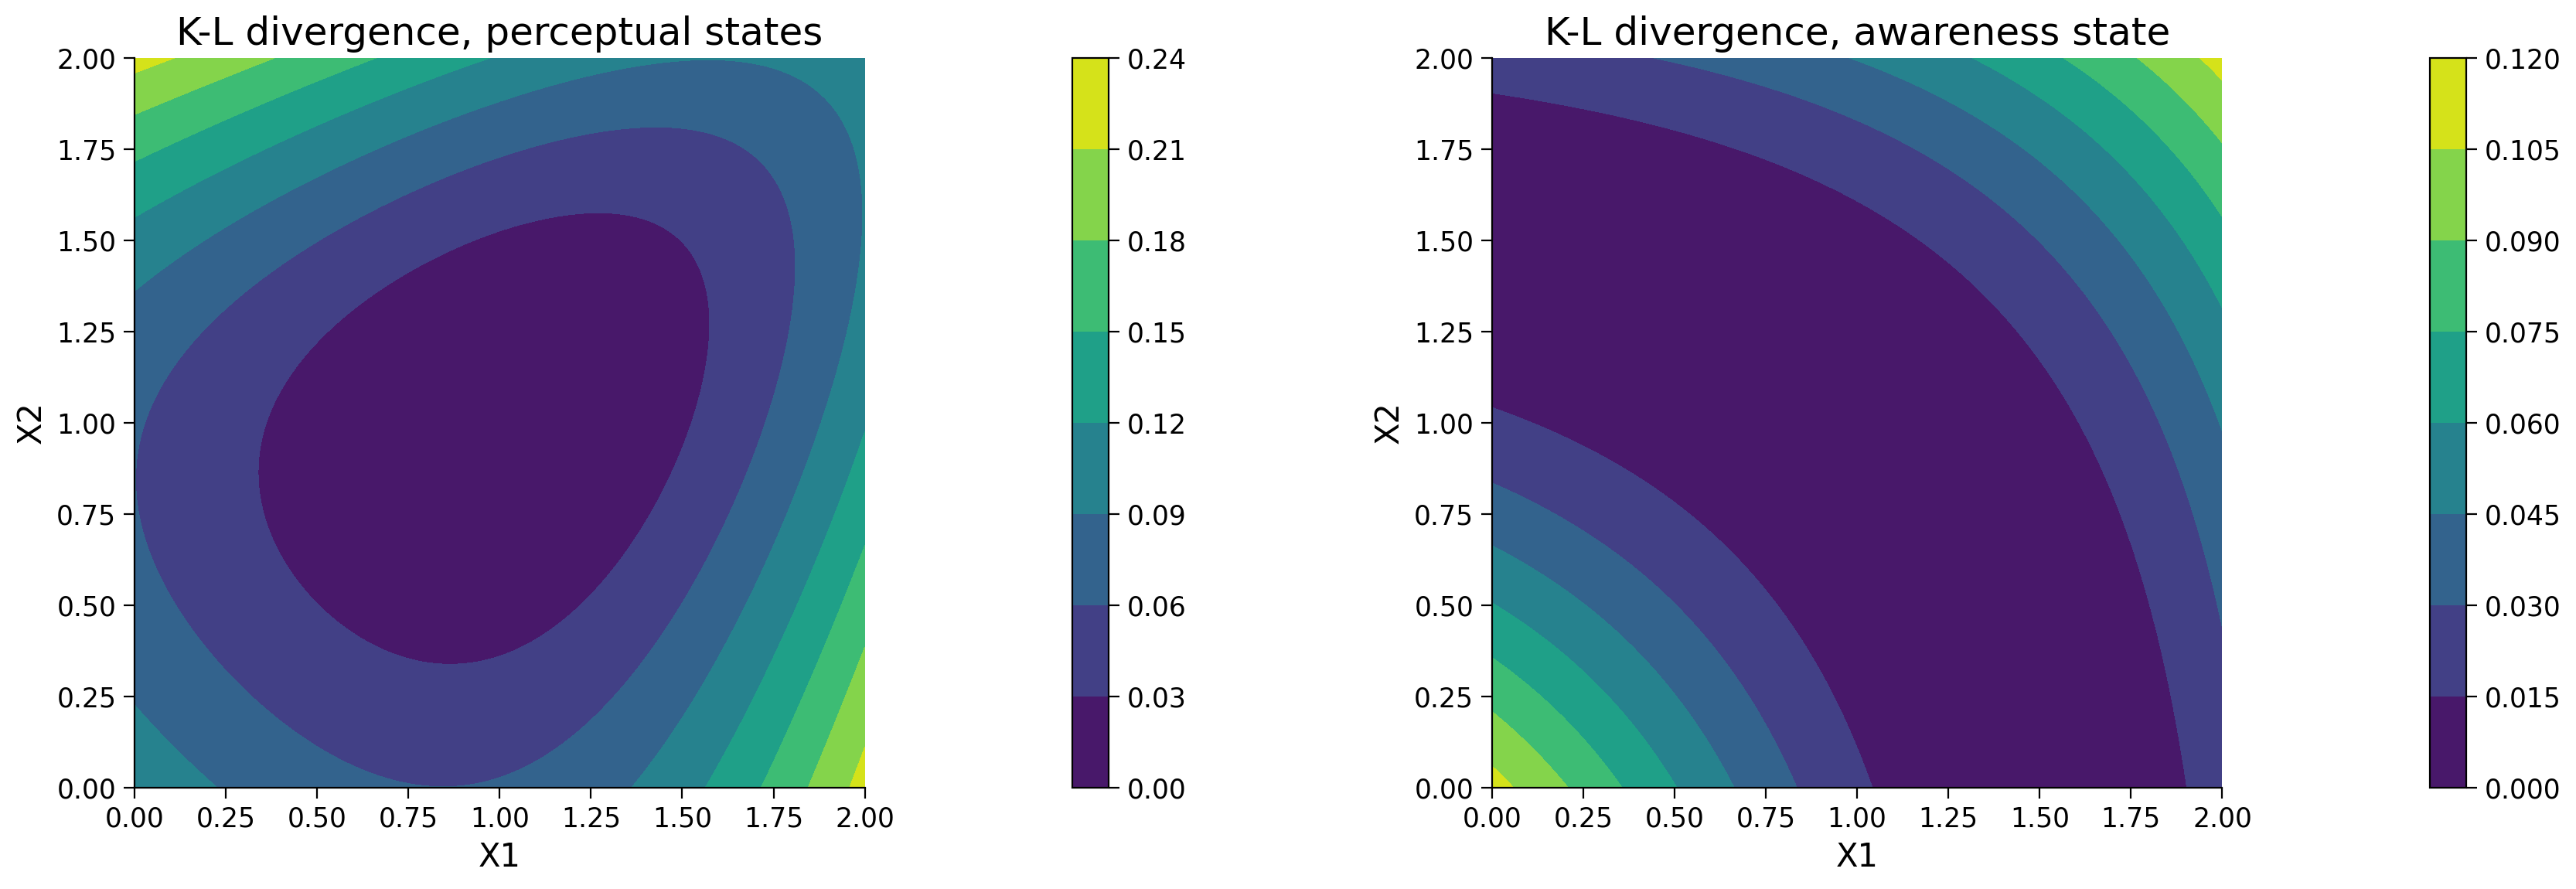

In [36]:
# Define the grid
xgrid = np.arange(0, 2.01, 0.01) 

# Define the means for the Gaussian distributions
mu = np.array([[0.5, 1.5], [1.5, 0.5], [0.5, 0.5]])

# Define the covariance matrix
Sigma = np.array([[1, 0], [0, 1]])

# Prior probabilities
Wprior = np.array([0.5, 0.5])
Aprior = 0.5

# Initialize arrays to hold confidence and posterior probability
confW = np.zeros((len(xgrid), len(xgrid)))
posteriorAware = np.zeros((len(xgrid), len(xgrid)))
KL_w = np.zeros((len(xgrid), len(xgrid)))
KL_A = np.zeros((len(xgrid), len(xgrid)))

# Compute confidence and posterior probability for each point in the grid
for i, xi in enumerate(xgrid):
    for j, xj in enumerate(xgrid):
        X = [xi, xj]
        post_w, post_A, KL_w[i, j], KL_A[i, j] = HOSS_evaluate(X, mu, Sigma, Aprior, Wprior)
        
        confW[i, j] = max(post_w[0], post_w[1])
        posteriorAware[i, j] = post_A[1]

# Calculate the mean K-L divergence for absent and present awareness states
KL_A_absent = np.mean(KL_A[posteriorAware < 0.5])
KL_A_present = np.mean(KL_A[posteriorAware >= 0.5])
KL_w_absent = np.mean(KL_w[posteriorAware < 0.5])
KL_w_present = np.mean(KL_w[posteriorAware >= 0.5])

# Plotting
plt.figure(figsize=(18, 6))

# K-L divergence, perceptual states
plt.subplot(1, 2, 1)
plt.contourf(xgrid, xgrid, KL_w.T, cmap='viridis')  
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('K-L divergence, perceptual states')
plt.axis('square')

# K-L divergence, awareness state
plt.subplot(1, 2, 2)
plt.contourf(xgrid, xgrid, KL_A.T, cmap='viridis')  
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('K-L divergence, awareness state')
plt.axis('square')

plt.show()

### Discussion point

Can you recognise the difference between the K-L divergence for the W-level and the one for the A-level?

### Hint

At the level of perceptual states W, there is substantial asymmetry in the K-L divergence expected when the model says ‘seen’ vs. ‘unseen’ (lefthand panel). This is due to the large belief updates invoked in the perceptual layer W by samples that deviate from the lower lefthand corner - from absence. In contrast, when we compute K-L divergence for the A-level (righthand panel), the level of prediction error is symmetric across seen and unseen decisions, leading to "hot" zones both at the upper righthand (present) and lower lefthand (absent) corners of the 2D space.

Intuitively, this means that at the W-level there's a noticeable difference in the K-L divergence values between "seen" and "unseen" predictions. This large difference is mainly due to significant updates in the model's beliefs at this level when the detected samples are far from what is expected under the condition of "absence." However, when we analyze the K-L divergence at the A-level, the discrepancies in prediction errors between "seen" and "unseen" are balanced. This creates equally strong responses in the model, whether something is detected or not detected.

We can also sort the K-L divergences as a function of whether the model "reported" presence or absence. As can be seen in the bar plots below, there is more asymmetry in the prediction error at the W compared to the A levels.

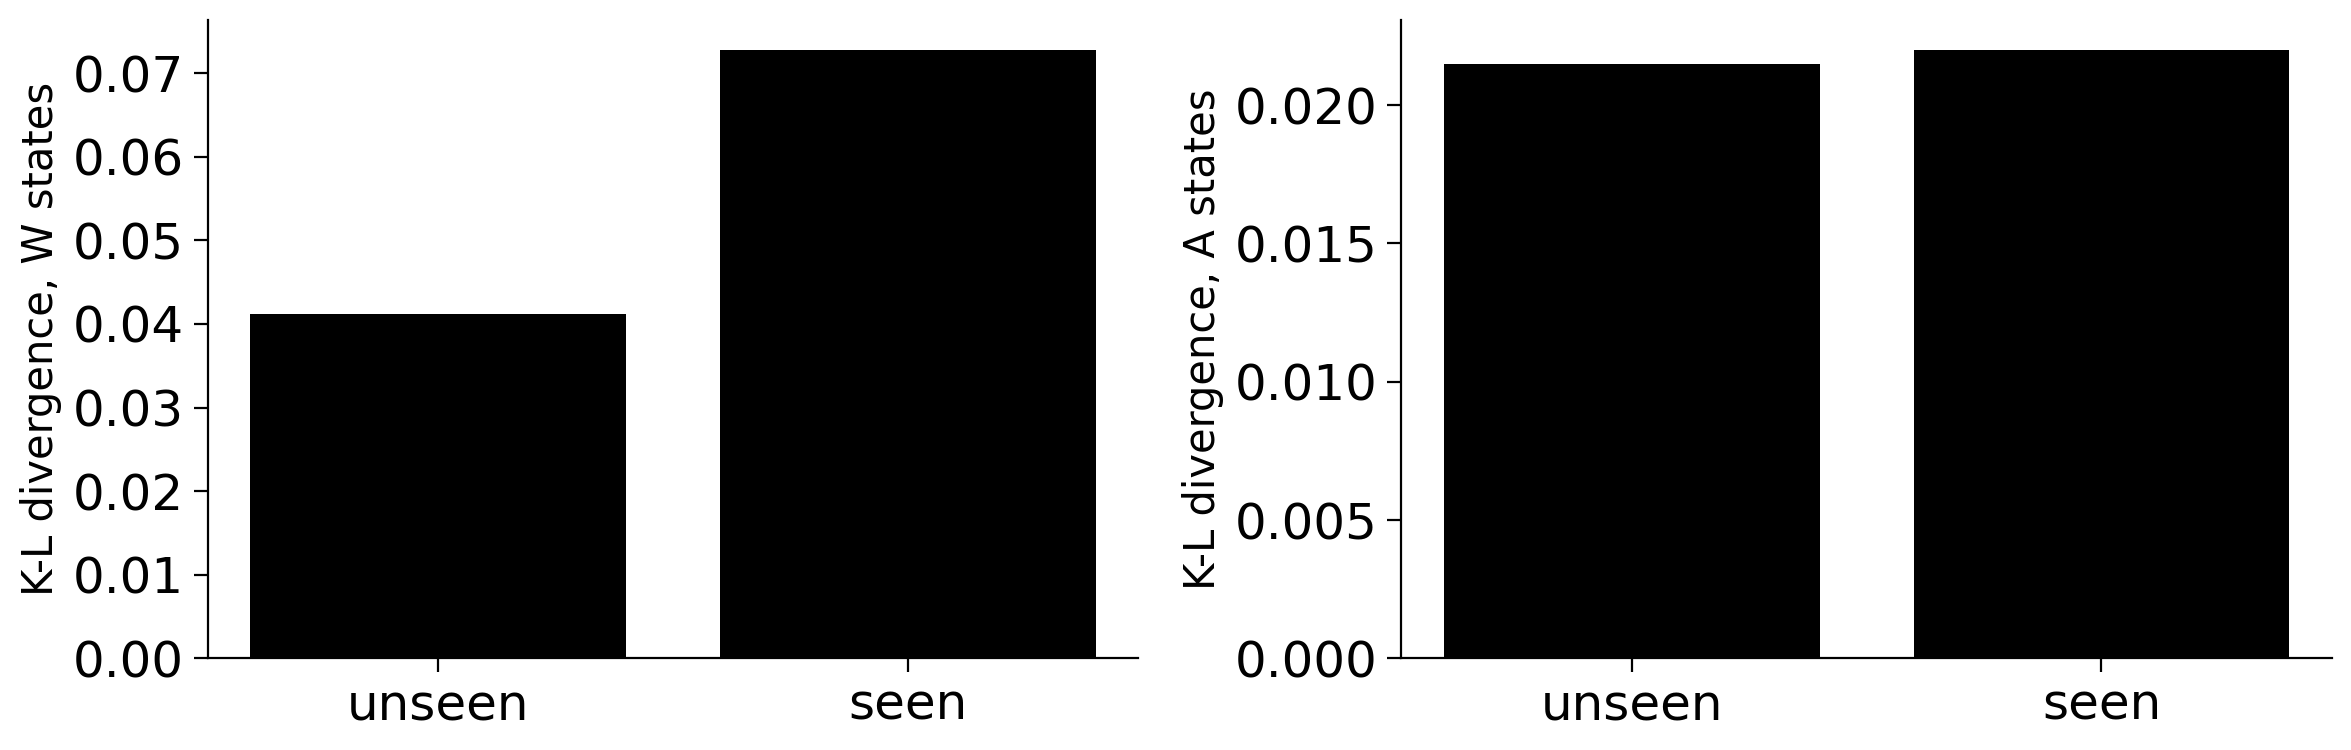

In [37]:
# Create figure with specified size
plt.figure(figsize=(12, 4))

# KL divergence for W states
plt.subplot(1, 2, 1)
plt.bar(['unseen', 'seen'], [KL_w_absent, KL_w_present], color='k')
plt.ylabel('K-L divergence, W states')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# KL divergence for A states
plt.subplot(1, 2, 2)
plt.bar(['unseen', 'seen'], [KL_A_absent, KL_A_present], color='k')
plt.ylabel('K-L divergence, A states')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()

# Show plot
plt.show()

### Simulate ignition (asymmetry vs. symmetry)

A notable feature about the HOSS architecture is that it is designed in a way that there are more possible states that the model can perceive when something is present compared to when something is absent. This setup leads to an interesting observation: when the model decides something is present, it tends to generate more prediction errors across its network. This accumulation of prediction errors is measured using Kullback-Leibler (K-L) divergence at various points in the network, particularly at a level called W.

This behavior, where there is more prediction error during presence decisions, relates closely to what researchers observe in the brain, known as global ignition responses. These responses are significant bursts of brain activity linked to the moment we become aware of something. Studies, such as those by Del Cul et al. (2007) and Dehaene and Changeux (2011), suggest that these responses support theories like the global workspace model, which explains consciousness as a kind of information sharing across different parts of the brain.

In our model, we explore this by adjusting the strength of the stimulus (referred to as sensory precision) and observing how it affects the prediction errors for both 'seen' and 'unseen' decisions at different levels of the network.

However, it's important to note that in the context of the HOSS architecture, these ignition-like responses are not the cause of information being shared globally across the network. Instead, they are more like side effects (epiphenomenal consequences) of other underlying computations. In simpler terms, these bursts of activity are results of what's happening deeper in the network, not the direct means of sharing information globally.

In [38]:
# Experiment parameters
mu = np.array([[3.5, 0.5], [0.5, 3.5], [0.5, 0.5]])
Nsubjects = 30
Ntrials = 600
cond = np.concatenate((np.ones(Ntrials//3), np.ones(Ntrials//3)*2, np.ones(Ntrials//3)*3))
Wprior = [0.5, 0.5]
Aprior = 0.5

# Sensory precision values
gamma = np.linspace(0.1, 10, 6)

# Initialize lists for results
all_KL_w_yes = []
sem_KL_w_yes = []
all_KL_w_no = []
sem_KL_w_no = []
all_KL_A_yes = []
sem_KL_A_yes = []
all_KL_A_no = []
sem_KL_A_no = []
all_prob_y = []

#################################################
## TODO for students: fill in the missing variables ##
# Fill out function and remove
raise NotImplementedError("Student exercise: fill in the missing variables")
#################################################

for y in tqdm(..., desc='Processing gammas'):
    Sigma = np.diag([1./np.sqrt(y)]*2)
    mean_KL_w = np.zeros((Nsubjects, 4))
    mean_KL_A = np.zeros((Nsubjects, 4))
    prob_y = np.zeros(Nsubjects)

    for s in tqdm(range(Nsubjects), desc=f'Subjects for gamma={y}', leave=False):
        KL_w = np.zeros(len(cond))
        KL_A = np.zeros(len(cond))
        posteriorAware = np.zeros(len(cond))

        # Generate sensory samples
        X = np.array([multivariate_normal.rvs(mean=mu[int(c)-1, :], cov=Sigma) for c in cond])

        # Model inversion for each trial
        for i, x in enumerate(X):
            post_w, post_A, KL_w[i], KL_A[i] = HOSS_evaluate(x, mu, Sigma, Aprior, Wprior)
            posteriorAware[i] = post_A[1]  # Assuming post_A is a tuple with awareness probability at index 1

        binaryAware = posteriorAware > 0.5
        for i in range(4):
            conditions = [(cond == 3), (cond != 3), (cond != 3), (cond == 3)]
            aware_conditions = [(binaryAware == 0), (binaryAware == 0), (binaryAware == 1), (binaryAware == 1)]
            mean_KL_w[s, i] = np.mean(KL_w[np.logical_and(aware_conditions[i], conditions[i])])
            mean_KL_A[s, i] = np.mean(KL_A[np.logical_and(aware_conditions[i], conditions[i])])

        prob_y[s] = np.mean(binaryAware[cond != 3])

    # Aggregate results across subjects
    all_KL_w_yes.append(np.mean(mean_KL_w[:, 2:4].flatten()))
    sem_KL_w_yes.append(np.std(mean_KL_w[:, 2:4].flatten()) / np.sqrt(Nsubjects))
    all_KL_w_no.append(np.mean(mean_KL_w[:, :2].flatten()))
    sem_KL_w_no.append(np.std(mean_KL_w[:, :2].flatten()) / np.sqrt(Nsubjects))
    all_KL_A_yes.append(np.mean(mean_KL_A[:, 2:4].flatten()))
    sem_KL_A_yes.append(np.std(mean_KL_A[:, 2:4].flatten()) / np.sqrt(Nsubjects))
    all_KL_A_no.append(np.mean(mean_KL_A[:, :2].flatten()))
    sem_KL_A_no.append(np.std(mean_KL_A[:, :2].flatten()) / np.sqrt(Nsubjects))
    all_prob_y.append(np.mean(prob_y))

# Create figure
plt.figure(figsize=(16, 4.67))

# First subplot: Probability of reporting "seen" for w_1 or w_2
plt.subplot(1, 3, 1)
plt.plot(gamma, all_prob_y, linewidth=2)
plt.xlabel('SOA (precision)')
plt.ylabel('Prob. report "seen" for w_1 or w_2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Second subplot: K-L divergence, perceptual states
plt.subplot(1, 3, 2)
plt.errorbar(gamma, all_KL_w_yes, yerr=sem_KL_w_yes, linewidth=2, label='Seen')
plt.errorbar(gamma, all_KL_w_no, yerr=sem_KL_w_no, linewidth=2, label='Unseen')
plt.legend(frameon=False)
plt.xlabel('SOA (precision)')
plt.ylabel('K-L divergence, perceptual states')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Third subplot: K-L divergence, awareness state
plt.subplot(1, 3, 3)
plt.errorbar(gamma, all_KL_A_yes, yerr=sem_KL_A_yes, linewidth=2, label='Seen')
plt.errorbar(gamma, all_KL_A_no, yerr=sem_KL_A_no, linewidth=2, label='Unseen')
plt.legend(frameon=False)
plt.xlabel('SOA (precision)')
plt.ylabel('K-L divergence, awareness state')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

NotImplementedError: Student exercise: fill in the missing variables

In [ ]:
# to_remove solution

# Experiment parameters
mu = np.array([[3.5, 0.5], [0.5, 3.5], [0.5, 0.5]])
Nsubjects = 30
Ntrials = 600
cond = np.concatenate((np.ones(Ntrials//3), np.ones(Ntrials//3)*2, np.ones(Ntrials//3)*3))
Wprior = [0.5, 0.5]
Aprior = 0.5

# Sensory precision values
gamma = np.linspace(0.1, 10, 6)

# Initialize lists for results
all_KL_w_yes = []
sem_KL_w_yes = []
all_KL_w_no = []
sem_KL_w_no = []
all_KL_A_yes = []
sem_KL_A_yes = []
all_KL_A_no = []
sem_KL_A_no = []
all_prob_y = []

for y in tqdm(gamma, desc='Processing gammas'):
    Sigma = np.diag([1./np.sqrt(y)]*2)
    mean_KL_w = np.zeros((Nsubjects, 4))
    mean_KL_A = np.zeros((Nsubjects, 4))
    prob_y = np.zeros(Nsubjects)

    for s in tqdm(range(Nsubjects), desc=f'Subjects for gamma={y}', leave=False):
        KL_w = np.zeros(len(cond))
        KL_A = np.zeros(len(cond))
        posteriorAware = np.zeros(len(cond))

        # Generate sensory samples
        X = np.array([multivariate_normal.rvs(mean=mu[int(c)-1, :], cov=Sigma) for c in cond])

        # Model inversion for each trial
        for i, x in enumerate(X):
            post_w, post_A, KL_w[i], KL_A[i] = HOSS_evaluate(x, mu, Sigma, Aprior, Wprior)
            posteriorAware[i] = post_A[1]  # Assuming post_A is a tuple with awareness probability at index 1

        binaryAware = posteriorAware > 0.5
        for i in range(4):
            conditions = [(cond == 3), (cond != 3), (cond != 3), (cond == 3)]
            aware_conditions = [(binaryAware == 0), (binaryAware == 0), (binaryAware == 1), (binaryAware == 1)]
            mean_KL_w[s, i] = np.mean(KL_w[np.logical_and(aware_conditions[i], conditions[i])])
            mean_KL_A[s, i] = np.mean(KL_A[np.logical_and(aware_conditions[i], conditions[i])])

        prob_y[s] = np.mean(binaryAware[cond != 3])

    # Aggregate results across subjects
    all_KL_w_yes.append(np.mean(mean_KL_w[:, 2:4].flatten()))
    sem_KL_w_yes.append(np.std(mean_KL_w[:, 2:4].flatten()) / np.sqrt(Nsubjects))
    all_KL_w_no.append(np.mean(mean_KL_w[:, :2].flatten()))
    sem_KL_w_no.append(np.std(mean_KL_w[:, :2].flatten()) / np.sqrt(Nsubjects))
    all_KL_A_yes.append(np.mean(mean_KL_A[:, 2:4].flatten()))
    sem_KL_A_yes.append(np.std(mean_KL_A[:, 2:4].flatten()) / np.sqrt(Nsubjects))
    all_KL_A_no.append(np.mean(mean_KL_A[:, :2].flatten()))
    sem_KL_A_no.append(np.std(mean_KL_A[:, :2].flatten()) / np.sqrt(Nsubjects))
    all_prob_y.append(np.mean(prob_y))

# Create figure
plt.figure(figsize=(16, 4.67))

# First subplot: Probability of reporting "seen" for w_1 or w_2
plt.subplot(1, 3, 1)
plt.plot(gamma, all_prob_y, linewidth=2)
plt.xlabel('SOA (precision)')
plt.ylabel('Prob. report "seen" for w_1 or w_2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Second subplot: K-L divergence, perceptual states
plt.subplot(1, 3, 2)
plt.errorbar(gamma, all_KL_w_yes, yerr=sem_KL_w_yes, linewidth=2, label='Seen')
plt.errorbar(gamma, all_KL_w_no, yerr=sem_KL_w_no, linewidth=2, label='Unseen')
plt.legend(frameon=False)
plt.xlabel('SOA (precision)')
plt.ylabel('K-L divergence, perceptual states')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Third subplot: K-L divergence, awareness state
plt.subplot(1, 3, 3)
plt.errorbar(gamma, all_KL_A_yes, yerr=sem_KL_A_yes, linewidth=2, label='Seen')
plt.errorbar(gamma, all_KL_A_no, yerr=sem_KL_A_no, linewidth=2, label='Unseen')
plt.legend(frameon=False)
plt.xlabel('SOA (precision)')
plt.ylabel('K-L divergence, awareness state')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.box(False)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

### Discussion point

Can you think of experiments that could distinguish between the HOSS and GWS accounts of ignition?


## Bonus section 1

### Train a first-order network

This section invites you to engage with a straightforward, auto-generated dataset on blindsight, originally introduced by Pasquali et al. in 2010. Blindsight is a fascinating condition where individuals who are cortically blind due to damage in their primary visual cortex can still respond to visual stimuli without conscious perception. This intriguing phenomenon underscores the intricate nature of sensory processing and the brain's ability to process information without conscious awareness.

In [ ]:
# Visualize the autogenerated data
initialize_global()
patterns_tensor, _ , _, _ = Generate_Patterns(patterns_number, num_units)
plot_signal_max_and_indicator(patterns_tensor)

The pre-training dataset for the network consisted of 200 patterns. These were evenly divided: half were purely noise (with unit activations randomly chosen between 0.0 and 0.02), and the other half represented potential stimuli. In the stimulus patterns, 99 out of 100 units had activations ranging between 0.0 and 0.02, with one unique unit having an activation between 0.0 and 1.0.

### Testing patterns

As we have seen before, the network underwent evaluations under three distinct conditions, each modifying the signal-to-noise ratio in a unique way to explore different degrees and types of blindness.

Suprathreshold stimulus condition: here, the network was exposed to the identical set of 200 patterns used during pre-training, testing the network's response to familiar inputs.

Subthreshold stimulus condition (blindsight simulation): this condition aimed to mimic blindsight. It was achieved by introducing a slight noise increment (+0.0012) to every input of the first-order network, barring the one designated as the stimulus. This setup tested the network's ability to discern faint signals amidst noise.

Low vision condition: to simulate low vision, the activation levels of the stimuli were reduced. Unlike the range from 0.0 to 1.0 used in pre-training, the stimuli's activation levels were adjusted to span from 0.0 to 0.3. This condition examined the network's capability to recognize stimuli with diminished intensity.

In [ ]:
# Compare your results with the patterns generate below
set_1, _ = create_patterns(0)
set_2, _ = create_patterns(1)
set_3, _ = create_patterns(2)

# Plot
plot_signal_max_and_indicator(set_1,"Suprathreshold stimulus")
plot_signal_max_and_indicator(set_2,"Subthreshold stimulus")
plot_signal_max_and_indicator(set_3,"Low Vision")

### Activity 1: Building a nework for a blindsight situation

In this activity, we'll construct a neural network model using our auto-generated dataset, focusing on blindsight scenarios. The model will primarily consist of fully connected layers, establishing a straightforward, first-order network. The aim here is to assess the basic network's performance.

### Steps to follow

1. Examine the network architecture: understand the structure of the neural network you're about to work with.
2. Visualize loss metrics: observe and analyze the network's performance during pre-training by visualizing the loss over epochs.
3. Evaluate the model: use the provided code snippets to calculate and interpret the model's accuracy, recall, and F1-score, giving you insight into the network's capabilities.

### Understanding the process

The goal is to gain a thorough comprehension of the network's architecture and to interpret the pre-training results visually. This will provide a clearer picture of the model's potential and limitations.

The network is designed as a backpropagation autoassociator. It features a 100-unit input layer, directly linked to a 60-unit hidden layer, which in turn connects to a 100-unit output layer. Initial connection weights are set within the range of -1.0 to 1.0 for the first-order network. To mitigate overfitting, dropout is employed within the network architecture. The architecture includes a configurable activation function. This flexibility allows for adjustments and tuning in Activity 3, aiming for optimal model performance.

In [ ]:
class FirstOrderNetwork(nn.Module):
    def __init__(self, hidden_units, data_factor, use_gelu):
        """
        Initializes the FirstOrderNetwork with specific configurations.

        Parameters:
        - hidden_units (int): The number of units in the hidden layer.
        - data_factor (int): Factor to scale the amount of data processed.
                             A factor of 1 indicates the default data amount,
                             while 10 indicates 10 times the default amount.
        - use_gelu (bool): Flag to use GELU (True) or ReLU (False) as the activation function.
        """
        super(FirstOrderNetwork, self).__init__()

        # Define the encoder, hidden, and decoder layers with specified units
        self.encoder = nn.Linear(100, hidden_units)
        self.hidden = nn.Linear(hidden_units, hidden_units)
        self.decoder = nn.Linear(hidden_units, 100)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.3)

        # Temperature parameter for activation sharpness control
        self.temperature = 1.0

        # Set the data factor
        self.data_factor = data_factor

        # Choose the activation function based on the use_gelu flag
        self.activation = nn.GELU() if use_gelu else nn.ReLU()

        # Other activation functions for various purposes
        self.sigmoid = torch.sigmoid
        self.softmax = nn.Softmax(dim=1)
        self.tanh = torch.tanh

        # Initialize network weights
        self.initialize_weights()

    def initialize_weights(self):
        """Initializes weights of the encoder, hidden, and decoder layers uniformly."""
        init.uniform_(self.encoder.weight, -1.0, 1.0)
        init.uniform_(self.hidden.weight, -1.0, 1.0)
        init.uniform_(self.decoder.weight, -1.0, 1.0)

    def forward(self, x):
        """
        Defines the forward pass through the network.

        Parameters:
        - x (Tensor): The input tensor to the network.

        Returns:
        - Tensor: The output of the network after passing through the layers and activations.
        """
        # Encoder step with dropout and sigmoid activation
        x = self.dropout(self.sigmoid(self.encoder(x) / self.temperature))

        # Hidden layer step with dropout and sigmoid activation
        x = self.dropout(self.sigmoid(self.hidden(x) / self.temperature))

        # Decoder step with dropout and sigmoid activation
        output = self.dropout(self.sigmoid(self.decoder(x) / self.temperature))

        # Adjust output based on a threshold
        output = torch.where(output > 0.5, output + 0.12, output)

        return output

For now, we will train the first order network only.

In [ ]:
# Define the architecture, optimizers, loss functions, and schedulers for pre training
hidden=60
factor=1
gelu=False
gam=0.99
stepsize=1

initialize_global()

# Networks instantiation
first_order_network = FirstOrderNetwork(hidden,factor,gelu).to(device)
second_order_network = SecondOrderNetwork(gelu).to(device) # We define it, but won't use it until activity 3

# Loss function
criterion_1 = nn.MSELoss()

# Optimizer
optimizer_1 = optim.SGD(first_order_network.parameters(), lr=learning_rate_1, momentum=momentum)

# Learning rate schedulers
scheduler_1 = StepLR(optimizer_1, step_size=stepsize, gamma=gam)

# Training loop
for epoch in range(n_epochs):
    # Generate training patterns and targets for each epoch.
    patterns_tensor, stim_present_tensor, stim_absent_tensor, order_2_tensor = Generate_Patterns(patterns_number, num_units)

    # Forward pass through the first-order network
    output_first_order = first_order_network(patterns_tensor)

    # Skip computations for the second-order network
    with torch.no_grad():
        # Potentially forward pass through the second-order network without tracking gradients
        output_second_order = second_order_network(patterns_tensor, output_first_order)

    # Calculate the loss for the first-order network (accuracy of stimulus representation)
    loss_1 = criterion_1(output_first_order, stim_present_tensor)

    # Backpropagate the first-order network's loss
    loss_1.backward()

    # Update first-order network weights
    optimizer_1.step()

    # Reset first-order optimizer gradients to zero for the next iteration
    optimizer_1.zero_grad()

    # Update the first-order scheduler
    scheduler_1.step()

    epoch_1_order[epoch] = loss_1.item()

# Plot training loss curve
pre_train_plots(epoch_1_order, epoch_2_order, "First order network training")

### Testing under 3 blindsight conditions

We will now use the testing auto-generated datasets from activity 1 to test the network's performance.

In [ ]:
# Prepare networks for testing by calling the configuration function
Testing_patterns, n_samples, loaded_model, loaded_model_2 = config_training(first_order_network, second_order_network, hidden, factor, gelu)

# Perform testing using the defined function and plot the results
f1_scores_high_wager, f1_scores_low_wager, results_for_plotting = testing(Testing_patterns, n_samples, loaded_model, loaded_model_2)

# Assuming plot_testing is defined, call it to display results
plot_testing(results_for_plotting, "Baseline")

## Bonus section 2

### Plot surfaces for content / awareness inferences

To explore the properties of the HOSS model, we can simulate inference at different levels of the hierarchy over the full 2D space of possible input X's. The left panel below shows that the probability of awareness (of any stimulus contents) rises in a graded manner from the lower left corner of the graph (low activation of any feature) to the upper right (high activation of both features). In contrast, the right panel shows that confidence in making a discrimination response (e.g. rightward vs. leftward) increases away from the major diagonal, as the model becomes sure that the sample was generated by either a leftward or rightward tilted stimulus. 

Together, the two surfaces make predictions about the relationships we might see between discrimination confidence and awareness in a simple psychophysics experiment. One notable prediction is that discrimination could still be possible - and lead to some degree of confidence - even when the higher-order node is "reporting" unawareness of the stimulus.

Now, let's get hands on and plot those auto-generated patterns!


In [ ]:
# Define the grid
xgrid = np.arange(0, 2.01, 0.01)

# Define the means for the Gaussian distributions
mu = np.array([[0.5, 1.5], [1.5, 0.5], [0.5, 0.5]])

# Define the covariance matrix
Sigma = np.array([[1, 0], [0, 1]])

# Prior probabilities
Wprior = np.array([0.5, 0.5])
Aprior = 0.5

# Initialize arrays to hold confidence and posterior probability
confW = np.zeros((len(xgrid), len(xgrid)))
posteriorAware = np.zeros((len(xgrid), len(xgrid)))
KL_w = np.zeros((len(xgrid), len(xgrid)))
KL_A = np.zeros((len(xgrid), len(xgrid)))

# Compute confidence and posterior probability for each point in the grid
for i, xi in enumerate(xgrid):
    for j, xj in enumerate(xgrid):
        X = [xi, xj]
        post_w, post_A, KL_w[i, j], KL_A[i, j] = HOSS_evaluate(X, mu, Sigma, Aprior, Wprior)
        confW[i, j] = max(post_w[0], post_w[1])
        posteriorAware[i, j] = post_A[1]

# Plotting
plt.figure(figsize=(10, 5))

# Posterior probability "seen"
plt.subplot(1, 2, 1)
plt.contourf(xgrid, xgrid, posteriorAware.T)
plt.colorbar()
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Posterior probability "seen"')
plt.axis('square')

# Confidence in identity
plt.subplot(1, 2, 2)
contour_set = plt.contourf(xgrid, xgrid, confW.T)
plt.colorbar()
plt.contour(xgrid, xgrid, posteriorAware.T, levels=[0.5], linewidths=4, colors=['white'])  # Line contour for threshold
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Confidence in identity')
plt.axis('square')

plt.show()

## Video

In [ ]:
# @title Video 4

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'v3H316M5TDY')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Video 5

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'DMs3L-5mCxk')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Video 6

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '6fYcB8wZ5Ko')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Video 7

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'WwY6rWeOCCc')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Video 8

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'UzYjWizcZRw')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)